# Tarea 2: Detección Automática de Idiomas

### Procesamiento de Lenguaje Natural

#### Autor: Alejandro Moreno Guerrero

16 de junio de 2025

In [1]:
import numpy as np
import string
import re
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
import scipy.sparse as sp
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV  # Para obtener probabilidades de LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import psutil  # Para medir uso de memoria
import seaborn as sns
import joblib  # Para guardar/cargar modelos y estimar su tamaño
import gc  # Garbage collector, útil para liberar memoria después de entrenar modelos grandes
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Preprocesamiento del texto

A continuación se definen las funciones que permitirán preprocesar los textos

In [2]:
def convertir_minusculas(texto):
    """
    Convierte todo el texto a minúsculas.
    
    Args:
        texto (str): Texto a procesar
    
    Returns:
        str: Texto en minúsculas
    """
    return texto.lower()

def eliminar_puntuacion(texto):
    """
    Elimina signos de puntuación del texto.
    
    Args:
        texto (str): Texto a procesar
    
    Returns:
        str: Texto sin signos de puntuación
    """
    # Utilizamos una traducción para eliminar toda la puntuación
    translator = str.maketrans('', '', string.punctuation)
    return texto.translate(translator)

def eliminar_numeros(texto):
    """
    Elimina números del texto.
    
    Args:
        texto (str): Texto a procesar
    
    Returns:
        str: Texto sin números
    """
    return re.sub(r'\d+', '', texto)

def eliminar_espacios_extra(texto):
    """
    Elimina espacios en blanco múltiples y al principio/final.
    
    Args:
        texto (str): Texto a procesar
    
    Returns:
        str: Texto con espacios normalizados
    """
    return re.sub(r'\s+', ' ', texto).strip()

In [3]:
def preprocesar_texto(texto, opciones=None):
    """
    Aplica un pipeline completo de preprocesamiento a un texto.
    
    Args:
        texto (str): Texto a procesar
        opciones (dict): Diccionario con opciones de preprocesamiento
            - minusculas (bool): Convertir a minúsculas
            - puntuacion (bool): Eliminar puntuación
            - numeros (bool): Eliminar números
    
    Returns:
        str or list: Texto preprocesado (como string o lista de tokens según la configuración)
    """
    # Opciones por defecto
    if opciones is None:
        opciones = {
            'minusculas': True,
            'puntuacion': True,
            'numeros': True,
            'devolver_tokens': False
        }
    
    # Aplicamos transformaciones básicas
    if opciones.get('minusculas', True):
        texto = convertir_minusculas(texto)
    
    if opciones.get('puntuacion', True):
        texto = eliminar_puntuacion(texto)
    
    if opciones.get('numeros', True):
        texto = eliminar_numeros(texto)
    
    # Tokenización
    tokens = word_tokenize(texto)
    
    
    # Limpiamos espacios
    texto_limpio = ' '.join(tokens)
    texto_limpio = eliminar_espacios_extra(texto_limpio)
    
    # Devolvemos tokens o texto según la configuración
    if opciones.get('devolver_tokens', False):
        return tokens
    else:
        return texto_limpio

In [4]:
configuracion_preprocesado = {
            'minusculas': True,
            'puntuacion': True,
            'numeros': True,
            'devolver_tokens': False
        }

### Carga del corpus

El corpus se carga, y simultáneamente, se preprocesa línea por línea. De esta manera es seguro que ninguna frase se queda fuera del rango de longitud deseado.

In [5]:
PATH_DS = "dataset/"

def cargar_dataset(idiomas,min_palabras,max_palabras,num_frases,preprocesar):
    X = []
    y = []
    print("Longitudes media por frase:")
    for id in idiomas:
        media_palabras = 0
        with open(PATH_DS + "/" + id + "/" + id + "_recortado", encoding="utf8") as file:
            counter_frases = 0
            for linea in file:
                if preprocesar:
                    frase = preprocesar_texto(linea,configuracion_preprocesado)
                else:
                    frase = linea
                num_palabras = len(frase.split())
                if min_palabras <= num_palabras and num_palabras <= max_palabras:
                    X.append(frase)
                    y.append(id)
                    media_palabras+=num_palabras
                    counter_frases += 1
                if counter_frases == num_frases:
                    break
            media_palabras/=counter_frases
            print(id,":",media_palabras)
    return np.array(X), np.array(y)

In [6]:
CLASES = np.array(["de", "el", "es", "fr", "it", "pt", "sv", "en"])
IDIOMAS = {"de":"alemán",
           "el":"griego",
           "es":"español",
           "fr":"francés",
           "it":"italiano",
           "pt":"portugués",
           "sv":"sueco",
           "en":"inglés"}

In [7]:
X, y = cargar_dataset(CLASES,2,15,10000,preprocesar=True)

Longitudes media por frase:
de : 9.749
el : 10.0754
es : 10.1346
fr : 10.285
it : 10.2011
pt : 10.1924
sv : 9.1227
en : 10.3685


### División del conjunto de datos

El conjunto de datos se divide en conjuntos de entrenamiento, validación y test

In [8]:
test_size = 0.15
val_size = 0.15
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,test_size=val_size/(1-test_size),random_state=42)

In [9]:
print(X_train[:10])

['nous devrons encore en discuter'
 'die küstenregionen mit ihrer seewirtschaft weisen ein großes entwicklungspotential auf'
 'exorto a assembleia a apoiar estas alterações'
 'βλέπω επίσης θετικά και την πρωτοβουλία της πορτογαλικής προεδρίας'
 'usted debe persistir en esto'
 'monsieur le président madame la commissaire cest une directive très importante'
 'αυτή η λύση εκφράστηκε θεωρητικά με τον όρο dιveloppement autocentrι αυτοδύναμη ανάπτυξη'
 'meine fraktion akzeptiert dies nur widerstrebend als schritt nach vorn'
 'é este o direito do parlamento europeu'
 'contribuiria além disso para reduzir as pressões migratórias']


Calculamos las proporciones de cada idioma en los diferentes conjuntos de datos. De esta manera nos aseguramos de que la división ha sido estratificada

Longitud de los conjuntos de datos:
entrenamiento: 56000 (70.0%)
test: 12000 (15.0%)
validación: 12000 (15.0%)

Distribución de categorías (porcentaje):


,Entrenamiento (%),Prueba (%),Validación (%)
de,12.526786,12.316667,12.558333
el,12.589286,12.066667,12.516667
en,12.546429,12.783333,12.000000
es,12.460714,12.625000,12.558333
fr,12.407143,12.683333,12.750000
it,12.580357,12.391667,12.233333
pt,12.385714,12.958333,12.575000
sv,12.503571,12.175000,12.808333


<Figure size 1200x600 with 0 Axes>

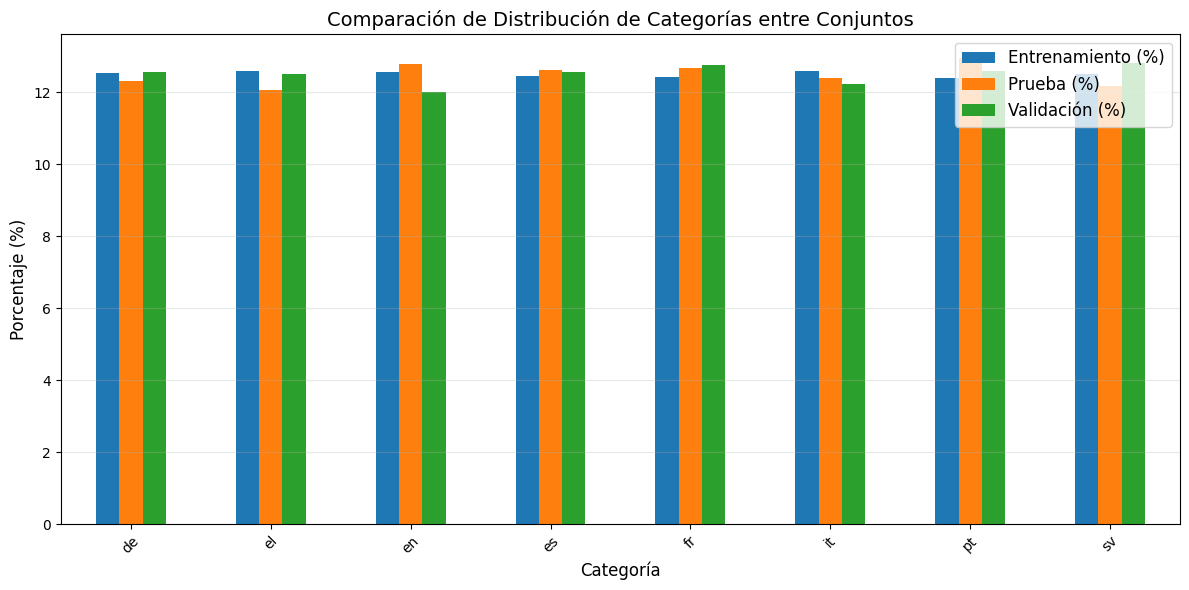

In [10]:
# Calculamos la proporción de cada categoría

cat, proporciones_train = np.unique(y_train, return_counts=True)
proporciones_train = proporciones_train * 100 / len(y_train)
proporciones_test = np.unique(y_test, return_counts=True)[1] * 100 / len(y_test)
proporciones_val = np.unique(y_val, return_counts=True)[1] * 100 / len(y_val)

# Creamos un dataframe para comparar las proporciones
df_balance = pd.DataFrame({
    'Entrenamiento (%)': proporciones_train,
    'Prueba (%)': proporciones_test,
    'Validación (%)': proporciones_val
},index=cat)

print("Longitud de los conjuntos de datos:")
print(f"entrenamiento: {len(y_train)} ({len(y_train)/len(y)*100}%)")
print(f"test: {len(y_test)} ({len(y_test)/len(y)*100}%)")
print(f"validación: {len(y_val)} ({len(y_val)/len(y)*100}%)")
print("")


print("Distribución de categorías (porcentaje):")
display(df_balance)

# Visualizamos la comparación
plt.figure(figsize=(12, 6))
df_balance.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Distribución de Categorías entre Conjuntos', fontsize=14)
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Análisis exploratorio del dataset

Analizamos las características del dataset, principalmente las distribuciones de longitud de las frases por cada idioma, así como de todo el dataset en conjunto

In [11]:
# Función para analizar características textuales
def analizar_caracteristicas_textuales(X,y):
    """
    Analiza las características textuales del dataset.
    
    Args:
        df: DataFrame con columnas de texto y longitud
        
    Returns:
        Estadísticas de las características textuales
    """

    df = pd.DataFrame({'text':X,
                       'longitud_caracteres':np.array([len(x) for x in X]),
                       'longitud_palabras':np.array([len(x.split()) for x in X]),
                       'idioma':y
                    })
    # Estadísticas generales


    stats_general = df[['longitud_caracteres', 'longitud_palabras']].describe()
    
    # Estadísticas por Idioma
    stats_por_intencion = df.groupby('idioma')[['longitud_caracteres', 'longitud_palabras']].agg(['mean', 'std', 'min', 'max'])
    
    # Visualizamos distribución de longitud en palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='longitud_palabras', bins=14, kde=False)
    plt.axvline(df['longitud_palabras'].mean(), color='red', linestyle='--', 
                label=f'Media: {df["longitud_palabras"].mean():.1f}')
    plt.axvline(df['longitud_palabras'].median(), color='green', linestyle='--', 
                label=f'Mediana: {df["longitud_palabras"].median():.1f}')
    plt.title('Distribución de Longitud en Palabras', fontsize=14)
    plt.xlabel('Número de Palabras', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Visualizamos longitud por idioma con violin plot
    plt.figure(figsize=(14, 8))
    ax = sns.violinplot(data=df, x='idioma', y='longitud_palabras', palette='viridis')
    plt.title('Distribución de Longitud en Palabras por idioma', fontsize=14)
    plt.xlabel('Idioma', fontsize=12)
    plt.ylabel('Número de Palabras', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Añadimos estadísticas específicas sobre cada violín
    for i, intent in enumerate(sorted(df['idioma'].unique())):
        intent_data = df[df['idioma'] == intent]['longitud_palabras']
        ax.text(i, intent_data.max() + 0.5, 
                f"Med: {intent_data.median():.1f}\nMax: {intent_data.max()}", 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Comparación de longitud media entre intenciones mediante barras
    plt.figure(figsize=(12, 6))
    longitud_media = df.groupby('idioma')['longitud_palabras'].mean().sort_values()
    ax = sns.barplot(x=longitud_media.index, y=longitud_media.values, palette='viridis')
    plt.title('Longitud Media de Consultas por idioma', fontsize=14)
    plt.xlabel('Idioma', fontsize=12)
    plt.ylabel('Número Medio de Palabras', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Añadimos valores a las barras
    for i, v in enumerate(longitud_media.values):
        ax.text(i, v + 0.1, f"{v:.1f}", ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return stats_general, stats_por_intencion

#### Distribución de longitud de las frases

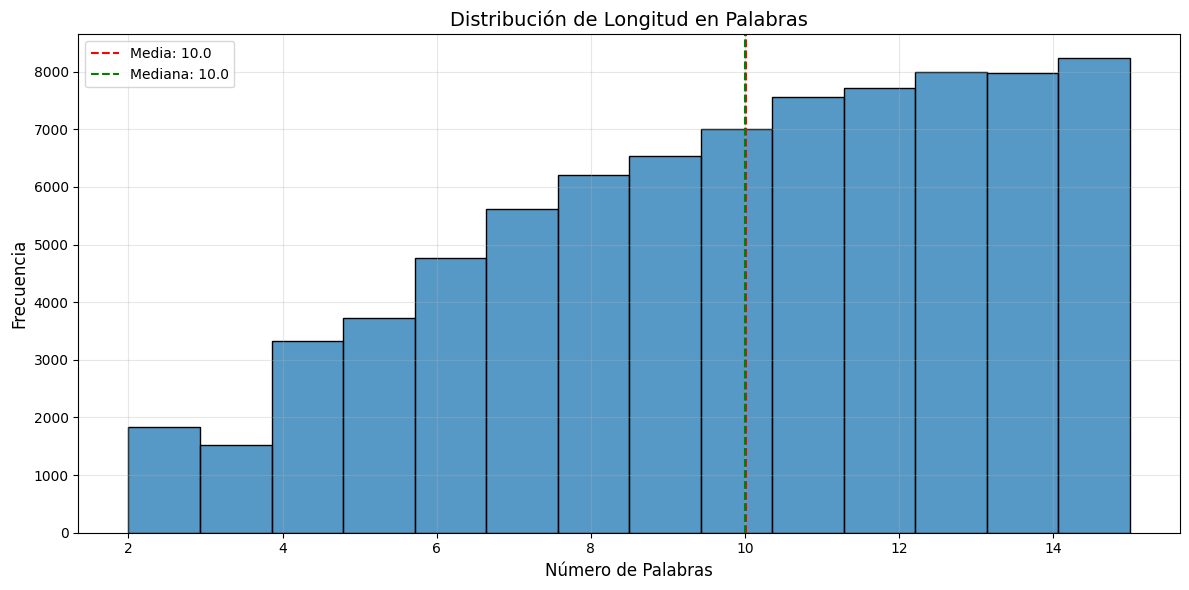

C:\Users\User\AppData\Local\Temp\ipykernel_8420\2237542848.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df, x='idioma', y='longitud_palabras', palette='viridis')


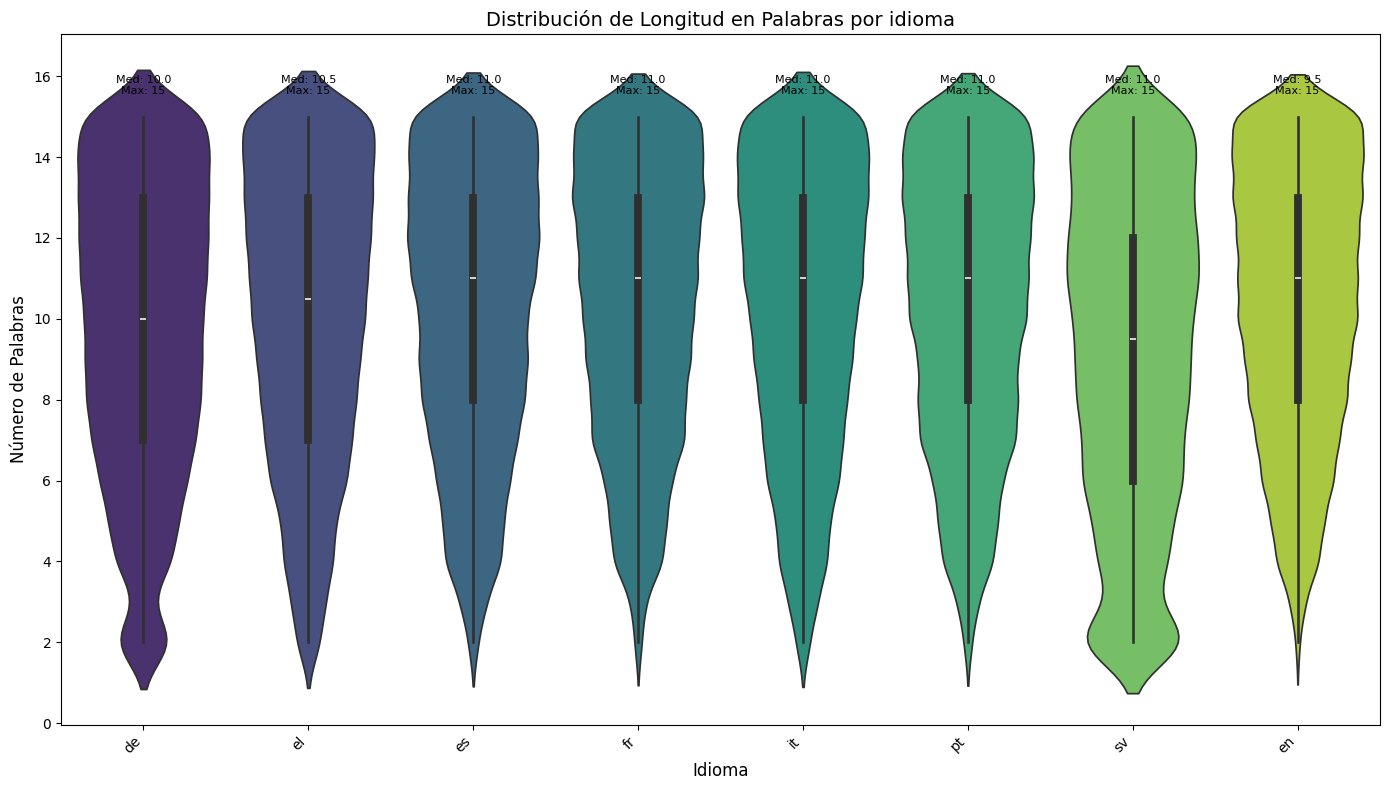

C:\Users\User\AppData\Local\Temp\ipykernel_8420\2237542848.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=longitud_media.index, y=longitud_media.values, palette='viridis')


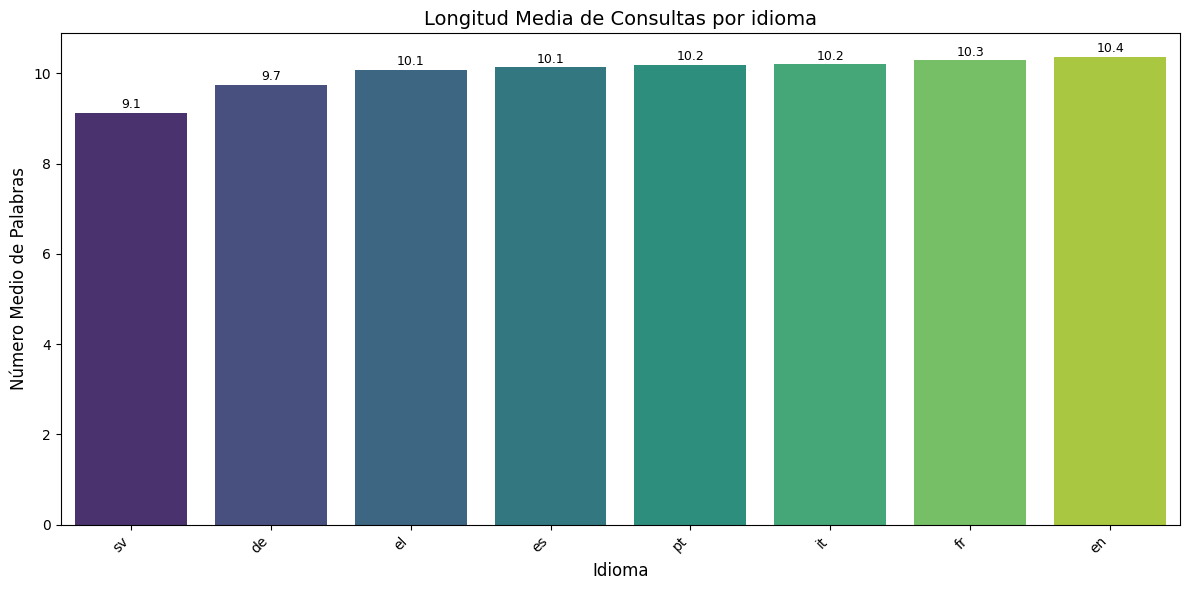


Estadísticas generales de longitud:


,longitud_caracteres,longitud_palabras
count,80000.000000,80000.000000
mean,63.394762,10.016087
std,24.758129,3.546750
min,3.000000,2.000000
25%,45.000000,7.000000
50%,65.000000,10.000000
75%,82.000000,13.000000
max,157.000000,15.000000



Estadísticas de longitud por idioma:


longitud_caracteres                     longitud_palabras            \
                      mean        std min  max              mean       std   
idioma                                                                       
de                 68.3819  28.333167   8  157            9.7490  3.648744   
el                 65.6248  24.955719   5  145           10.0754  3.562357   
en                 59.4453  21.304253   6  127           10.3685  3.299242   
es                 61.7607  22.463969   5  133           10.1346  3.442509   
fr                 62.7901  22.691305   8  132           10.2850  3.360343   
it                 66.9390  24.906817   3  149           10.2011  3.489080   
pt                 63.6276  22.988679   8  132           10.1924  3.389946   
sv                 58.5887  27.787878   7  145            9.1227  3.974723   

                
       min max  
idioma          
de       2  15  
el       2  15  
en       2  15  
es       2  15  
fr       2  15  
it       2  15  
pt       2  15  
sv       2  15

In [12]:
# Analizamos características textuales
stats_general, stats_por_intencion = analizar_caracteristicas_textuales(X,y)

print("\nEstadísticas generales de longitud:")
display(stats_general)

print("\nEstadísticas de longitud por idioma:")
display(stats_por_intencion)

Como se puede ver todas las diferentes categorías presentan distribuciones de longitud de palabras similares. La media global de longitud se sitúa en 10 palabras. En este dataset son más predominantes las frases con mayor longitud de palabras.

### Implementación de TF-IDF

In [13]:
def crear_tfidf(X_train, X_test, X_val, min_df=2, max_df=0.95, 
               norm='l2', uso_idf=True, smooth_idf=True, sublinear_tf=False):
    """
    Crea una representación TF-IDF para los conjuntos de entrenamiento y prueba.
    
    Args:
        X_train: Conjunto de entrenamiento
        X_test: Conjunto de prueba
        X_val: Conjunto de validación
        min_df: Frecuencia mínima de documento para incluir un término
        max_df: Frecuencia máxima de documento para incluir un término
        norm: Normalización aplicada ('l1', 'l2' o None)
        uso_idf: Si se usa la ponderación IDF
        smooth_idf: Si se aplica suavizado al IDF
        sublinear_tf: Si se aplica escala sublineal a TF (1 + log(tf))
        
    Returns:
        tuple: (vectorizador, características_train, características_test, características_val)
    """
    # Inicializamos el vectorizador
    print(f"Creando representación TF-IDF (min_df={min_df}, max_df={max_df}, norm={norm}, "
          f"uso_idf={uso_idf}, smooth_idf={smooth_idf}, sublinear_tf={sublinear_tf})...")
    
    vectorizador = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        norm=norm,
        use_idf=uso_idf,
        smooth_idf=smooth_idf,
        sublinear_tf=sublinear_tf
    )
    
    # Entrenamos con los datos de entrenamiento y transformamos
    inicio = time.time()
    X_train_tfidf = vectorizador.fit_transform(X_train)
    tiempo_train = time.time() - inicio
    
    # Transformamos los datos de prueba
    inicio = time.time()
    X_test_tfidf = vectorizador.transform(X_test)
    tiempo_test = time.time() - inicio

    # Transformamos los datos de validación
    inicio = time.time()
    X_val_tfidf = vectorizador.transform(X_val)
    tiempo_val = time.time() - inicio
    
    # Obtenemos información sobre el vocabulario
    vocabulario = vectorizador.get_feature_names_out()
    
    print(f"Representación creada en {tiempo_train+tiempo_test+tiempo_val:.2f} segundos:")
    print(f"- Tiempo de fit_transform (train): {tiempo_train:.2f} segundos")
    print(f"- Tiempo de transform (test): {tiempo_test:.2f} segundos")
    print(f"- Tiempo de transform (val): {tiempo_val:.2f} segundos")
    print(f"- Tamaño del vocabulario: {len(vocabulario)} términos")
    print(f"- Dimensiones matriz train: {X_train_tfidf.shape}")
    print(f"- Dimensiones matriz test: {X_test_tfidf.shape}")
    print(f"- Dimensiones matriz val: {X_val_tfidf.shape}")
    print(f"- Densidad matriz train: {X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1]):.5f}")
    
    return vectorizador, X_train_tfidf, X_test_tfidf, X_val_tfidf

In [14]:
# Creamos la representación TF-IDF estándar
vectorizador_tfidf, X_train_tfidf, X_test_tfidf, X_val_tfidf = crear_tfidf(
    X_train, 
    X_test,
    X_val,
    min_df=2,
    max_df=0.95,
    norm='l2',
    uso_idf=True,
    smooth_idf=True,
    sublinear_tf=False
)

Creando representación TF-IDF (min_df=2, max_df=0.95, norm=l2, uso_idf=True, smooth_idf=True, sublinear_tf=False)...
Representación creada en 1.07 segundos:
- Tiempo de fit_transform (train): 0.78 segundos
- Tiempo de transform (test): 0.14 segundos
- Tiempo de transform (val): 0.15 segundos
- Tamaño del vocabulario: 30743 términos
- Dimensiones matriz train: (56000, 30743)
- Dimensiones matriz test: (12000, 30743)
- Dimensiones matriz val: (12000, 30743)
- Densidad matriz train: 0.00028


### Entrenamiento de clasificadores

Esta función se utilizará para entrenar los tres clasificadores vectoriales

In [15]:
def entrenar_clasificador(clasificador, X_train, y_train, X_test, y_test, nombre_clasificador):
    """
    Entrena un clasificador y mide métricas de rendimiento computacional.
    
    Args:
        clasificador: Modelo de clasificador a entrenar
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        X_test: Características de prueba
        y_test: Etiquetas de prueba
        nombre_clasificador: Nombre descriptivo del clasificador
    
    Returns:
        tuple: (clasificador_entrenado, tiempo_entrenamiento, tiempo_prediccion, memoria_modelo, accuracy)
    """
    print(f"Entrenando {nombre_clasificador}...")
    
    # Registramos estado inicial de memoria
    proceso = psutil.Process()
    memoria_inicial = proceso.memory_info().rss / (1024 * 1024)  # En MB
    
    # Medimos el tiempo de entrenamiento
    inicio = time.time()
    clasificador.fit(X_train, y_train)
    tiempo_entrenamiento = time.time() - inicio
    
    # Registramos estado final de memoria y calculamos diferencia
    memoria_final = proceso.memory_info().rss / (1024 * 1024)  # En MB
    memoria_usada = memoria_final - memoria_inicial
    
    # Estimamos el tamaño del modelo guardado
    with open('temp_model.joblib', 'wb') as f:
        joblib.dump(clasificador, f)
    
    tamaño_modelo = os.path.getsize('temp_model.joblib') / (1024 * 1024)  # En MB
    os.remove('temp_model.joblib')  # Limpiamos el archivo temporal
    
    # Medimos el tiempo de predicción
    inicio = time.time()
    y_pred = clasificador.predict(X_test)
    tiempo_prediccion = time.time() - inicio
    
    # Calculamos accuracy inicial
    accuracy = np.mean(y_pred == y_test)
    
    # Imprimimos información de rendimiento
    print(f"  Tiempo de entrenamiento: {tiempo_entrenamiento:.2f} segundos")
    print(f"  Tiempo de predicción: {tiempo_prediccion:.2f} segundos")
    print(f"  Memoria utilizada durante entrenamiento: {memoria_usada:.2f} MB")
    print(f"  Tamaño del modelo guardado: {tamaño_modelo:.2f} MB")
    print(f"  Accuracy inicial: {accuracy:.4f}")
    print("-" * 50)
    
    return clasificador, tiempo_entrenamiento, tiempo_prediccion, tamaño_modelo, accuracy

### Determinación de hiperparámetros

Para cada clasificador, se hará una búsqueda de sus hiperparámetros. En este caso, solo disponemos de uno para cada uno de los clasificadores. Se evalúan 4 posibles valores para determinar el mejor en cada caso.

In [16]:
param_NB = {'alpha':[0.001,0.01,0.1,1]}
param_RL = {'C':[0.01,0.1,1,10]}
param_SVC = {'C':[0.01,0.1,1,10]}

best_param_NB = None
best_acc = 0
for p in param_NB['alpha']:
    model = MultinomialNB(alpha=p)
    modelo, tiempo_entr, tiempo_pred, tamaño, acc = entrenar_clasificador(model, X_train_tfidf, y_train, X_val_tfidf, y_val, "NB")
    if acc > best_acc:
        best_acc = acc
        best_param_NB = p

print("Mejor alpha para NB:",best_param_NB, "|",best_acc, "accuracy")

best_param_LR = None
best_acc = 0
for p in param_RL['C']:
    model = LogisticRegression(C=p, max_iter=1000, solver='liblinear', multi_class='ovr', random_state=42)
    modelo, tiempo_entr, tiempo_pred, tamaño, acc = entrenar_clasificador(model, X_train_tfidf, y_train, X_val_tfidf, y_val, "LR")
    if acc > best_acc:
        best_acc = acc
        best_param_LR = p

print("Mejor C para RL:",best_param_LR, "|",best_acc, "accuracy")

best_param_SVC = None
best_acc = 0
for p in param_SVC['C']:
    model = CalibratedClassifierCV(LinearSVC(C=p, random_state=42))
    modelo, tiempo_entr, tiempo_pred, tamaño, acc = entrenar_clasificador(model, X_train_tfidf, y_train, X_val_tfidf, y_val, "SVC")
    if acc > best_acc:
        best_acc = acc
        best_param_SVC = p

print("Mejor C para SVC:",best_param_SVC, "|",best_acc, "accuracy")


Entrenando NB...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 5.53 MB
  Tamaño del modelo guardado: 3.75 MB
  Accuracy inicial: 0.9971
--------------------------------------------------
Entrenando NB...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 2.40 MB
  Tamaño del modelo guardado: 3.75 MB
  Accuracy inicial: 0.9975
--------------------------------------------------
Entrenando NB...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 7.18 MB
  Tamaño del modelo guardado: 3.75 MB
  Accuracy inicial: 0.9978
--------------------------------------------------
Entrenando NB...
  Tiempo de entrenamiento: 0.03 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 5.70 MB
  Tamaño del modelo guardado: 3.75 MB
  Accuracy inicial: 0.9976

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Tiempo de entrenamiento: 1.82 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 3.86 MB
  Tamaño del modelo guardado: 1.88 MB
  Accuracy inicial: 0.9874
--------------------------------------------------
Entrenando LR...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Tiempo de entrenamiento: 2.05 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 0.41 MB
  Tamaño del modelo guardado: 1.88 MB
  Accuracy inicial: 0.9917
--------------------------------------------------
Entrenando LR...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Tiempo de entrenamiento: 2.76 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 0.41 MB
  Tamaño del modelo guardado: 1.88 MB
  Accuracy inicial: 0.9952
--------------------------------------------------
Entrenando LR...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Tiempo de entrenamiento: 4.48 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 2.25 MB
  Tamaño del modelo guardado: 1.88 MB
  Accuracy inicial: 0.9962
--------------------------------------------------
Mejor C para RL: 10 | 0.9961666666666666 accuracy
Entrenando SVC...
  Tiempo de entrenamiento: 7.11 segundos
  Tiempo de predicción: 0.04 segundos
  Memoria utilizada durante entrenamiento: 10.78 MB
  Tamaño del modelo guardado: 9.39 MB
  Accuracy inicial: 0.9912
--------------------------------------------------
Entrenando SVC...
  Tiempo de entrenamiento: 10.04 segundos
  Tiempo de predicción: 0.04 segundos
  Memoria utilizada durante entrenamiento: 11.72 MB
  Tamaño del modelo guardado: 9.39 MB
  Accuracy inicial: 0.9962
--------------------------------------------------
Entrenando SVC...
  Tiempo de entrenamiento: 9.91 segundos
  Tiempo de predicción: 0.05 segundos
  Memoria utilizada durante entrenamiento: 9.30 MB
  Tamaño del modelo guard

Ahora definimos los clasificadores a partir de los mejores hiperparámetros encontrados

In [17]:
# Definimos los clasificadores a entrenar
clasificadores = {
    'Naive Bayes Multinomial': MultinomialNB(alpha=best_param_NB),  # alpha es el parámetro de suavizado
    'Regresión Logística': LogisticRegression(C=best_param_LR, max_iter=1000, solver='liblinear', multi_class='ovr', random_state=42),
    'SVM Lineal': CalibratedClassifierCV(LinearSVC(C=best_param_SVC, random_state=42)),  # CalibratedClassifierCV permite obtener probabilidades
}

# Diccionario para almacenar resultados
resultados_clasificadores = {}

# Entrenamos cada clasificador y almacenamos resultados
for nombre, clasificador in clasificadores.items():
    # Entrenamos el clasificador y obtenemos métricas
    modelo, tiempo_entr, tiempo_pred, tamaño, acc = entrenar_clasificador(
        clasificador, X_train_tfidf, y_train, X_test_tfidf, y_test, nombre
    )
    
    # Guardamos los resultados
    resultados_clasificadores[nombre] = {
        'modelo': modelo,
        'tiempo_entrenamiento': tiempo_entr,
        'tiempo_prediccion': tiempo_pred,
        'tamaño_modelo': tamaño,
        'accuracy_inicial': acc
    }
    
    # Ejecutamos el recolector de basura para liberar memoria
    gc.collect()

Entrenando Naive Bayes Multinomial...
  Tiempo de entrenamiento: 0.04 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 3.26 MB
  Tamaño del modelo guardado: 3.75 MB
  Accuracy inicial: 0.9985
--------------------------------------------------
Entrenando Regresión Logística...


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Tiempo de entrenamiento: 3.76 segundos
  Tiempo de predicción: 0.00 segundos
  Memoria utilizada durante entrenamiento: 6.72 MB
  Tamaño del modelo guardado: 1.88 MB
  Accuracy inicial: 0.9962
--------------------------------------------------
Entrenando SVM Lineal...
  Tiempo de entrenamiento: 9.23 segundos
  Tiempo de predicción: 0.05 segundos
  Memoria utilizada durante entrenamiento: 10.34 MB
  Tamaño del modelo guardado: 9.39 MB
  Accuracy inicial: 0.9972
--------------------------------------------------


### Evaluación de los clasificadores vectoriales

Para cada uno de los clasificadores anteriores, se analizan varios resultados:
- Matriz de confusión
- Resultados por validación cruzada
- Curva de aprendizaje
- Visualización de errores cometidos

In [18]:
def evaluar_clasificador_completo(modelo, X_train, y_train, X_test, y_test, nombre_modelo):
    """
    Realiza una evaluación exhaustiva de un clasificador utilizando múltiples métricas.
    
    Args:
        modelo: Modelo entrenado
        X_train: Características de entrenamiento
        y_train: Etiquetas de entrenamiento
        X_test: Características de prueba
        y_test: Etiquetas de prueba
        nombre_modelo: Nombre del modelo para mostrar en resultados
        
    Returns:
        dict: Diccionario con todas las métricas calculadas
    """
    print(f"\n{'='*80}\nEVALUACIÓN EXHAUSTIVA: {nombre_modelo}\n{'='*80}")
    
    # 1. Predicciones en conjunto de prueba
    inicio = time.time()
    y_pred = modelo.predict(X_test)
    tiempo_pred = time.time() - inicio
    print(f"Tiempo de predicción para {len(y_test)} muestras: {tiempo_pred:.4f} segundos")
    
    # 2. Calculamos métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro'
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    # 3. Mostramos resumen de métricas
    print("\nMétricas globales:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro-Precision: {precision_macro:.4f}")
    print(f"Macro-Recall: {recall_macro:.4f}")
    print(f"Macro-F1: {f1_macro:.4f}")
    print(f"Weighted-Precision: {precision_weighted:.4f}")
    print(f"Weighted-Recall: {recall_weighted:.4f}")
    print(f"Weighted-F1: {f1_weighted:.4f}")
    
    # 4. Informe de clasificación detallado
    informe = classification_report(y_test, y_pred, output_dict=True)
    print("\nInforme de clasificación detallado:")
    print(classification_report(y_test, y_pred))
    
    # 5. Convertimos el informe a DataFrame para análisis
    df_informe = pd.DataFrame(informe).transpose()
    # Eliminamos filas de resumen para visualización por categoría
    df_por_categoria = df_informe.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    
    # 6. Visualizamos las métricas por categoría
    plt.figure(figsize=(15, 8))
    
    # Precision por categoría
    plt.subplot(1, 3, 1)
    sns.barplot(x=df_por_categoria.index, y='precision', data=df_por_categoria, palette='viridis')
    plt.title('Precision por Categoría', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Recall por categoría
    plt.subplot(1, 3, 2)
    sns.barplot(x=df_por_categoria.index, y='recall', data=df_por_categoria, palette='viridis')
    plt.title('Recall por Categoría', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # F1-score por categoría
    plt.subplot(1, 3, 3)
    sns.barplot(x=df_por_categoria.index, y='f1-score', data=df_por_categoria, palette='viridis')
    plt.title('F1-Score por Categoría', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 7. Calculamos y mostramos matriz de confusión
    mat_confusion = confusion_matrix(y_test, y_pred)
    clases = sorted(np.unique(y_train))
    
    # Guardamos todos los resultados en un diccionario
    resultados = {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'informe': informe,
        'matriz_confusion': mat_confusion,
        'y_pred': y_pred,
        'tiempo_prediccion': tiempo_pred
    }
    
    return resultados

In [19]:
def visualizar_matriz_confusion(matriz, clases, nombre_modelo, normalizar=True):
    """
    Visualiza una matriz de confusión con etiquetas y normalización opcional.
    
    Args:
        matriz: Matriz de confusión a visualizar
        clases: Lista de nombres de clases
        nombre_modelo: Nombre del modelo para el título
        normalizar: Si se debe normalizar la matriz por filas
    """
    plt.figure(figsize=(10, 8))
    
    if normalizar:
        # Normalizamos por filas (verdadera clase)
        matriz_norm = matriz.astype('float') / matriz.sum(axis=1)[:, np.newaxis]
        matriz_mostrar = matriz_norm
        vmax = 1.0
        fmt = '.2f'
        titulo_norm = "normalizada"
    else:
        matriz_mostrar = matriz
        vmax = matriz.max()
        fmt = 'd'
        titulo_norm = "absoluta"
    
    # Creamos el mapa de calor
    sns.heatmap(matriz_mostrar, annot=matriz, fmt=fmt, cmap='Blues', 
                xticklabels=clases, yticklabels=clases, vmin=0, vmax=vmax)
    
    plt.title(f'Matriz de Confusión {titulo_norm} - {nombre_modelo}', fontsize=14)
    plt.ylabel('Clase Verdadera', fontsize=12)
    plt.xlabel('Clase Predicha', fontsize=12)
    
    # Mejora para matrices grandes: rotamos etiquetas de ejes
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

In [20]:
def realizar_validacion_cruzada(modelo, X, y, cv=5, nombre_modelo=""):
    """
    Realiza validación cruzada con múltiples métricas.
    
    Args:
        modelo: Modelo a evaluar
        X: Características
        y: Etiquetas
        cv: Número de folds para validación cruzada
        nombre_modelo: Nombre del modelo para mostrar en resultados
        
    Returns:
        dict: Diccionario con resultados de cada métrica por fold
    """
    print(f"\n{'='*80}\nVALIDACIÓN CRUZADA: {nombre_modelo}\n{'='*80}")
    
    # Definimos las métricas a evaluar
    metricas = {
        'accuracy': make_scorer(accuracy_score),
        'precision_macro': make_scorer(precision_score, average='macro'),
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'precision_weighted': make_scorer(precision_score, average='weighted'),
        'recall_weighted': make_scorer(recall_score, average='weighted'),
        'f1_weighted': make_scorer(f1_score, average='weighted')
    }
    
    # Configuramos la validación cruzada
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Ejecutamos la validación cruzada
    inicio = time.time()
    scores = cross_validate(modelo, X, y, cv=kf, scoring=metricas, n_jobs=-1)
    tiempo_total = time.time() - inicio
    
    print(f"Validación cruzada completada en {tiempo_total:.2f} segundos")
    
    # Procesamos y mostramos resultados
    resultados = {}
    print("\nResultados por métrica:")
    
    for metrica in metricas.keys():
        scores_metrica = scores[f'test_{metrica}']
        media = np.mean(scores_metrica)
        std = np.std(scores_metrica)
        
        resultados[metrica] = {
            'scores': scores_metrica,
            'media': media,
            'std': std
        }
        
        print(f"{metrica}: {media:.4f} (±{std:.4f})")
    
    # Visualizamos los resultados
    plt.figure(figsize=(12, 6))
    
    # Preparamos datos para visualización
    metricas_nombres = list(resultados.keys())
    medias = [resultados[m]['media'] for m in metricas_nombres]
    stds = [resultados[m]['std'] for m in metricas_nombres]
    
    # Mejores nombres para visualización
    metricas_etiquetas = [n.replace('_', ' ').title() for n in metricas_nombres]
    
    # Creamos gráfico con barras de error
    plt.bar(metricas_etiquetas, medias, yerr=stds, 
            capsize=5, color=sns.color_palette('viridis', len(metricas_nombres)))
    
    plt.title(f'Resultados de Validación Cruzada - {nombre_modelo}', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return resultados

In [21]:
def generar_curva_aprendizaje(estimador, X, y, nombre, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Genera y visualiza una curva de aprendizaje para un clasificador.
    
    Args:
        estimador: Modelo de clasificador a evaluar
        X: Características
        y: Etiquetas
        nombre: Nombre del clasificador para mostrar
        cv: Número de folds para validación cruzada
        train_sizes: Tamaños relativos del conjunto de entrenamiento a evaluar
        
    Returns:
        tuple: (train_sizes, train_scores, test_scores)
    """
    print(f"\n{'='*80}\nCURVA DE APRENDIZAJE: {nombre}\n{'='*80}")
    
    from sklearn.model_selection import learning_curve
    
    # Configuramos la validación cruzada
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculamos curvas de aprendizaje
    inicio = time.time()
    train_sizes_abs, train_scores, test_scores = learning_curve(
        estimador, X, y, 
        train_sizes=train_sizes,
        cv=kf, 
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    tiempo_total = time.time() - inicio
    
    print(f"Curva de aprendizaje calculada en {tiempo_total:.2f} segundos")
    
    # Calculamos media y desviación estándar para los scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Mostramos valores numéricos
    print("\nScores por tamaño de entrenamiento:")
    print("| % Datos | Muestras | Train Score | Test Score |")
    print("|---------|----------|-------------|------------|")
    for i, size in enumerate(train_sizes_abs):
        pct = train_sizes[i] * 100
        print(f"| {pct:5.1f}% | {size:8d} | {train_mean[i]:.4f} ± {train_std[i]:.4f} | {test_mean[i]:.4f} ± {test_std[i]:.4f} |")
    
    # Visualizamos la curva de aprendizaje
    plt.figure(figsize=(12, 6))
    
    # Convertimos tamaños absolutos a porcentajes para mejor visualización
    sizes_pct = [s/X.shape[0]*100 for s in train_sizes_abs]
    
    # Score de entrenamiento
    plt.fill_between(sizes_pct, train_mean - train_std, train_mean + train_std, 
                    alpha=0.1, color='blue')
    plt.plot(sizes_pct, train_mean, 'o-', color='blue', label='Score de entrenamiento')
    
    # Score de validación
    plt.fill_between(sizes_pct, test_mean - test_std, test_mean + test_std, 
                    alpha=0.1, color='orange')
    plt.plot(sizes_pct, test_mean, 'o-', color='orange', label='Score de validación cruzada')
    
    # Formato del gráfico
    plt.title(f'Curva de Aprendizaje - {nombre}', fontsize=14)
    plt.xlabel('Porcentaje del conjunto de entrenamiento', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=12)
    
    # Añadimos líneas horizontales opcionales para referencia
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='_nolegend_')  # Línea de baseline
    plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='_nolegend_')  # Accuracy perfecta
    
    plt.tight_layout()
    plt.show()
    
    return train_sizes_abs, train_scores, test_scores

In [22]:
def analizar_errores_clasificador(y_true, y_pred, textos, nombre_modelo, n_ejemplos=2):
    """
    Analiza en detalle los errores de clasificación para comprender sus patrones.
    
    Args:
        y_true: Etiquetas verdaderas
        y_pred: Etiquetas predichas
        textos: Serie con los textos originales
        nombre_modelo: Nombre del modelo para mostrar
        n_ejemplos: Número de ejemplos a mostrar por tipo de error
        
    Returns:
        DataFrame: DataFrame con análisis de errores
    """
    print(f"\n{'='*80}\nANÁLISIS DE ERRORES: {nombre_modelo}\n{'='*80}")
    
    # Encontramos indices donde la predicción es incorrecta
    indices_error = np.where(y_true != y_pred)[0]
    
    # Si no hay errores, terminamos
    if len(indices_error) == 0:
        print("No se encontraron errores en las predicciones.")
        return pd.DataFrame()
    
    # Creamos un DataFrame para analizar los errores
    df_errores = pd.DataFrame({
        'Texto': textos[indices_error],
        'Clase_Verdadera': y_true[indices_error],
        'Clase_Predicha': y_pred[indices_error]
    })
    
    # Calculamos la tasa de error global
    tasa_error = len(indices_error) / len(y_true) * 100
    print(f"Tasa de error global: {len(indices_error)}/{len(y_true)} ({tasa_error:.2f}%)\n")
    
    # Analizamos errores por par de clases (confusión)
    print("Análisis de errores por pares de clases:")
    errores_por_par = df_errores.groupby(['Clase_Verdadera', 'Clase_Predicha']).size().reset_index(name='Conteo')
    errores_por_par = errores_por_par.sort_values('Conteo', ascending=False)
    print(errores_por_par)
    
    # Analizamos proporción de error por clase verdadera
    print("\nPorcentaje de errores por clase verdadera:")
    # Contamos el total por clase verdadera en el conjunto original
    total_por_clase = pd.Series(y_true).value_counts().to_dict()
    # Contamos errores por clase verdadera
    errores_por_clase = df_errores['Clase_Verdadera'].value_counts().to_dict()
    
    for clase in sorted(total_por_clase.keys()):
        total = total_por_clase.get(clase, 0)
        errores = errores_por_clase.get(clase, 0)
        tasa = errores / total * 100 if total > 0 else 0
        print(f"  {clase}: {errores}/{total} ({tasa:.2f}%)")
    
    # Visualizamos los tipos de error más comunes
    plt.figure(figsize=(12, 6))
    plt.title('Tipos de Error más Comunes', fontsize=14)
    
    # Limitamos a los 8 tipos de error más comunes para visualización
    errores_top = errores_por_par.head(8)
    # Creamos etiquetas combinadas para el eje X
    etiquetas_error = [f"{row['Clase_Verdadera']} → {row['Clase_Predicha']}" for _, row in errores_top.iterrows()]
    
    plt.bar(etiquetas_error, errores_top['Conteo'], color=sns.color_palette('viridis', len(errores_top)))
    plt.xlabel('Tipo de Error (Verdadera → Predicha)', fontsize=12)
    plt.ylabel('Número de Errores', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Mostramos ejemplos de los errores más comunes
    print("\nEjemplos de los errores más comunes:\n")
    for _, row in errores_por_par.head(3).iterrows():
        true_class = row['Clase_Verdadera']
        pred_class = row['Clase_Predicha']
        count = row['Conteo']
        
        print(f"{'='*40}")
        print(f"Error: {true_class} clasificado como {pred_class} ({count} casos)")
        print(f"{'='*40}")
        
        # Filtramos ejemplos de este tipo de error
        ejemplos = df_errores[
            (df_errores['Clase_Verdadera'] == true_class) & 
            (df_errores['Clase_Predicha'] == pred_class)
        ].head(n_ejemplos)
        
        # Mostramos cada ejemplo
        for i, (_, ejemplo) in enumerate(ejemplos.iterrows(), 1):
            texto = ejemplo['Texto']
            print(f"\nEjemplo {i}:")
            print(texto[:300] + "..." if len(texto) > 300 else texto)
            print("\n")
    
    return df_errores


####################################################################################################
EVALUACIÓN COMPLETA DEL CLASIFICADOR: Naive Bayes Multinomial
####################################################################################################

EVALUACIÓN EXHAUSTIVA: Naive Bayes Multinomial
Tiempo de predicción para 12000 muestras: 0.0030 segundos

Métricas globales:
Accuracy: 0.9985
Macro-Precision: 0.9985
Macro-Recall: 0.9985
Macro-F1: 0.9985
Weighted-Precision: 0.9985
Weighted-Recall: 0.9985
Weighted-F1: 0.9985

Informe de clasificación detallado:
              precision    recall  f1-score   support

          de       1.00      1.00      1.00      1478
          el       1.00      1.00      1.00      1448
          en       1.00      1.00      1.00      1534
          es       1.00      1.00      1.00      1515
          fr       1.00      1.00      1.00      1522
          it       1.00      1.00      1.00      1487
          pt       1.00      1.00      1.00

C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='precision', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='recall', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='f1-score', data=df_

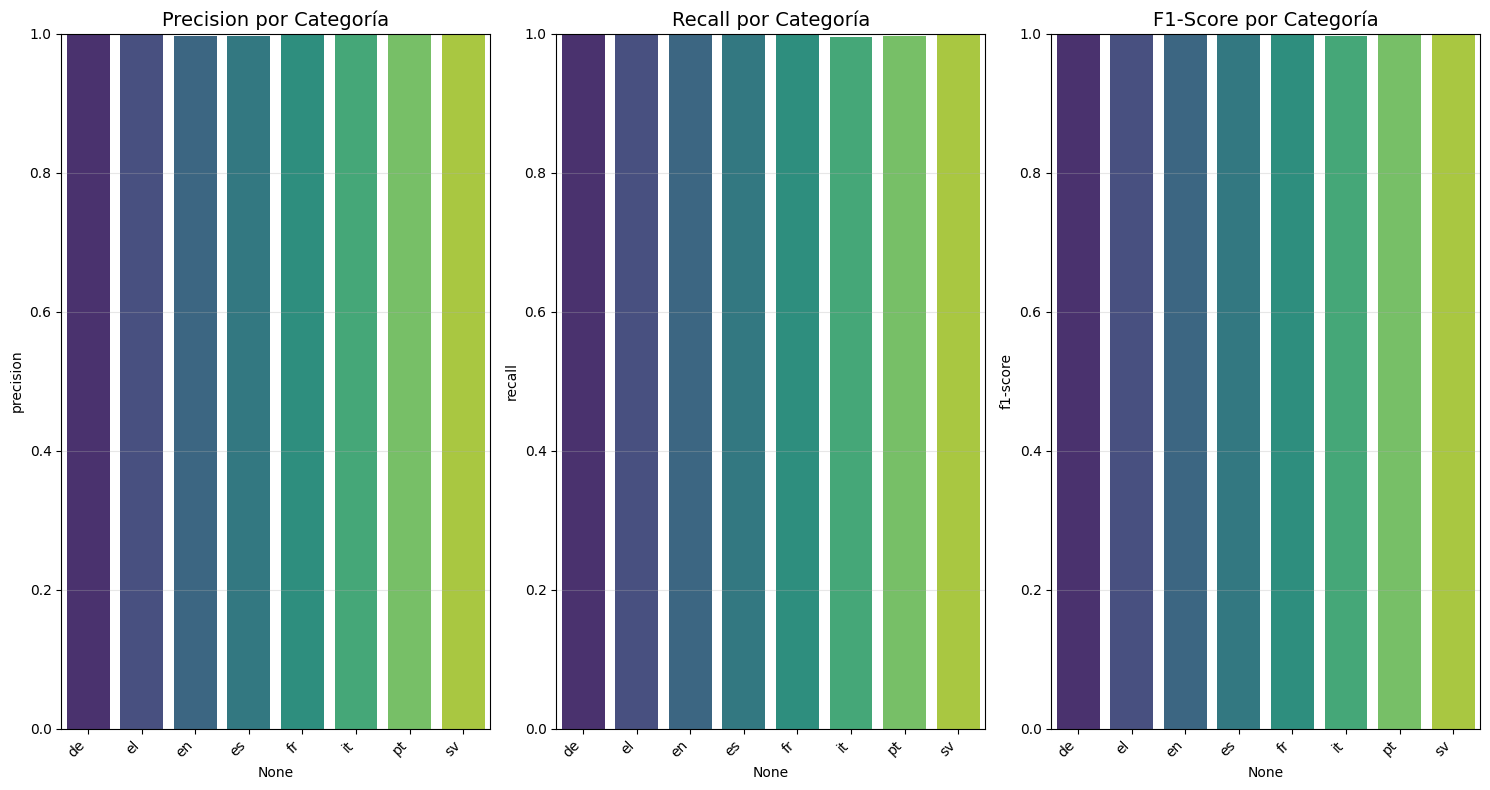


Matriz de confusión sin normalizar:


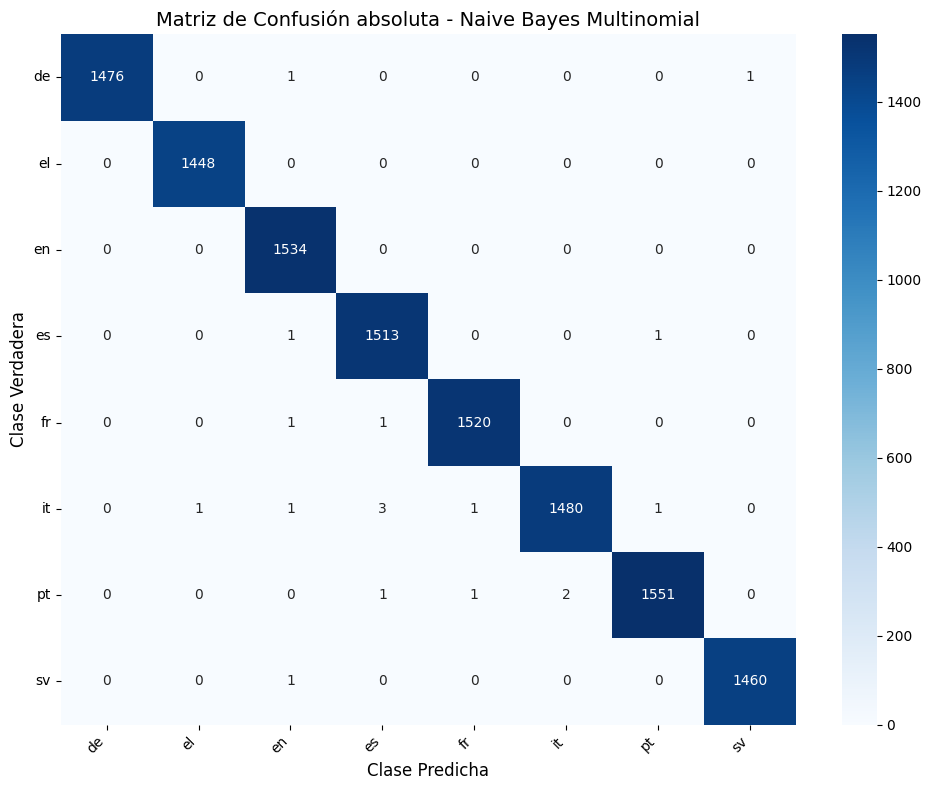


Matriz de confusión normalizada por filas (clase verdadera):


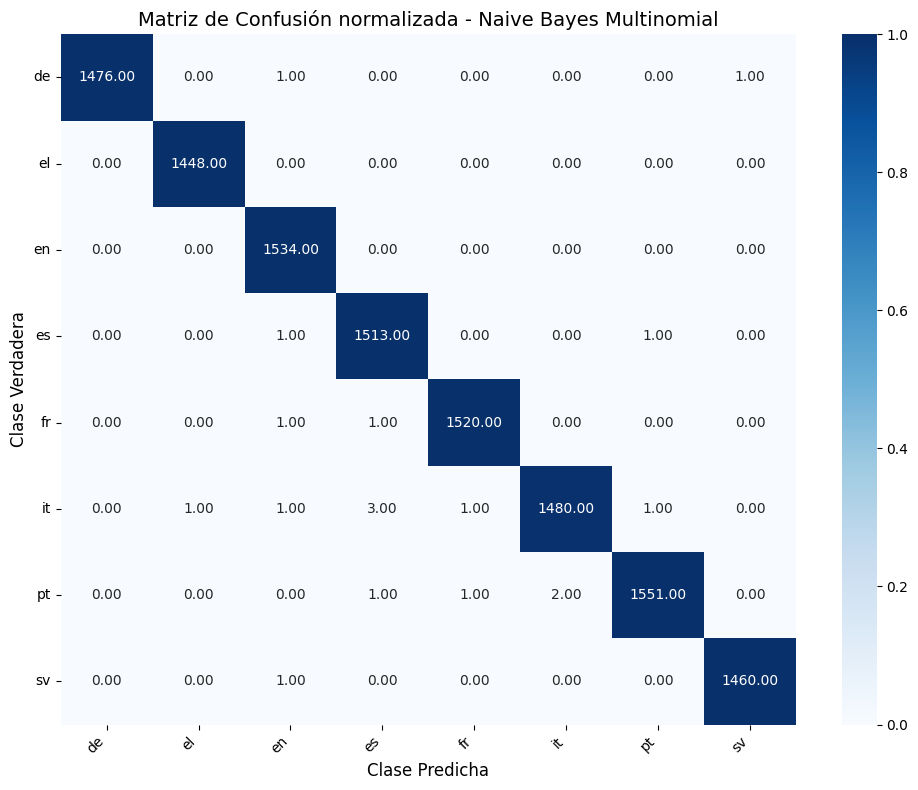


VALIDACIÓN CRUZADA: Naive Bayes Multinomial
Validación cruzada completada en 2.50 segundos

Resultados por métrica:
accuracy: 0.9982 (±0.0006)
precision_macro: 0.9982 (±0.0006)
recall_macro: 0.9982 (±0.0006)
f1_macro: 0.9982 (±0.0006)
precision_weighted: 0.9982 (±0.0006)
recall_weighted: 0.9982 (±0.0006)
f1_weighted: 0.9982 (±0.0006)


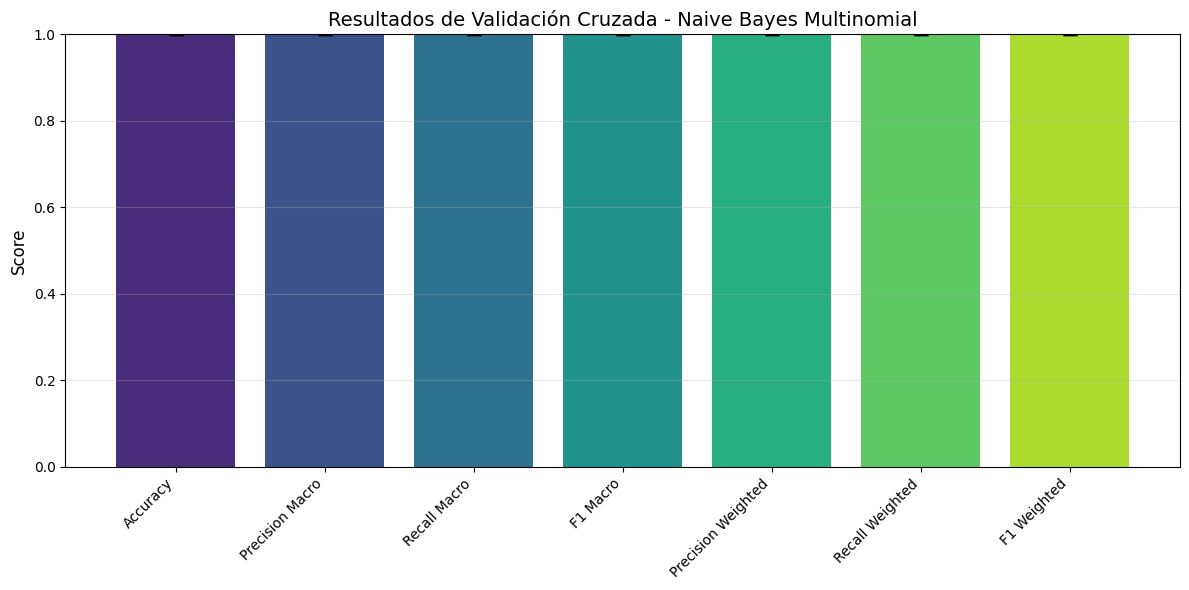


CURVA DE APRENDIZAJE: Naive Bayes Multinomial
Curva de aprendizaje calculada en 2.25 segundos

Scores por tamaño de entrenamiento:
| % Datos | Muestras | Train Score | Test Score |
|---------|----------|-------------|------------|
|  10.0% |     4480 | 0.9984 ± 0.0002 | 0.9956 ± 0.0007 |
|  20.0% |     8960 | 0.9988 ± 0.0002 | 0.9971 ± 0.0004 |
|  30.0% |    13440 | 0.9989 ± 0.0002 | 0.9976 ± 0.0005 |
|  40.0% |    17920 | 0.9991 ± 0.0002 | 0.9977 ± 0.0005 |
|  50.0% |    22400 | 0.9991 ± 0.0001 | 0.9978 ± 0.0005 |
|  60.0% |    26880 | 0.9992 ± 0.0002 | 0.9978 ± 0.0005 |
|  70.0% |    31360 | 0.9992 ± 0.0001 | 0.9980 ± 0.0005 |
|  80.0% |    35840 | 0.9991 ± 0.0001 | 0.9981 ± 0.0006 |
|  90.0% |    40320 | 0.9990 ± 0.0001 | 0.9981 ± 0.0005 |
| 100.0% |    44800 | 0.9990 ± 0.0001 | 0.9982 ± 0.0006 |


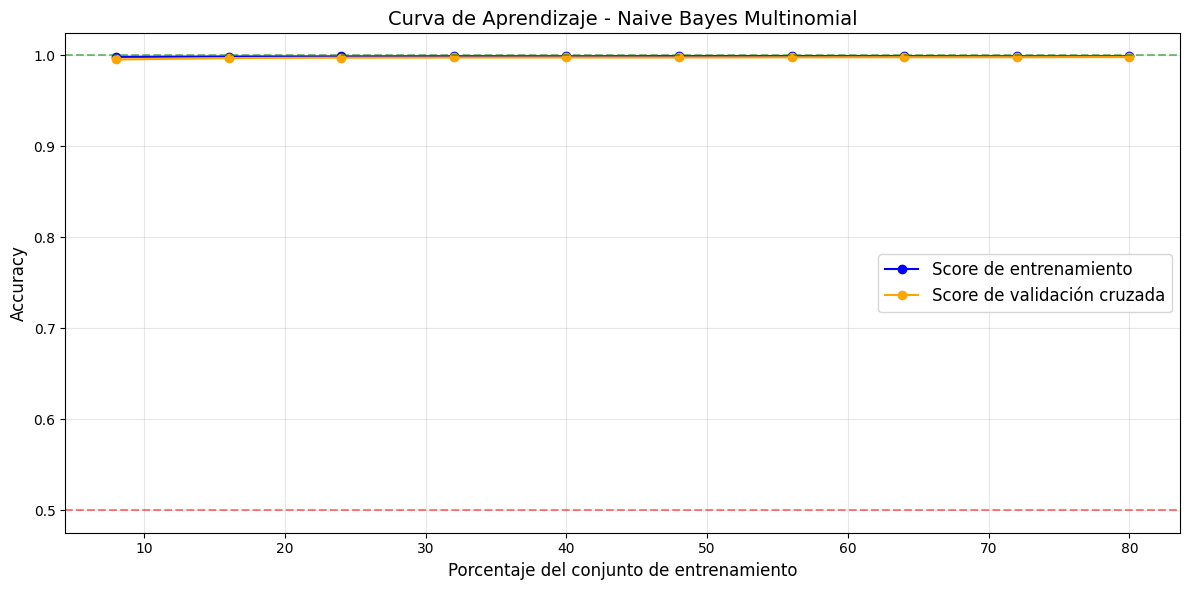


ANÁLISIS DE ERRORES: Naive Bayes Multinomial
Tasa de error global: 18/12000 (0.15%)

Análisis de errores por pares de clases:
   Clase_Verdadera Clase_Predicha  Conteo
8               it             es       3
13              pt             it       2
0               de             en       1
1               de             sv       1
2               es             en       1
3               es             pt       1
4               fr             en       1
5               fr             es       1
6               it             el       1
7               it             en       1
9               it             fr       1
10              it             pt       1
11              pt             es       1
12              pt             fr       1
14              sv             en       1

Porcentaje de errores por clase verdadera:
  de: 2/1478 (0.14%)
  el: 0/1448 (0.00%)
  en: 0/1534 (0.00%)
  es: 2/1515 (0.13%)
  fr: 2/1522 (0.13%)
  it: 7/1487 (0.47%)
  pt: 4/1555 (0.26%)
  sv: 1/14

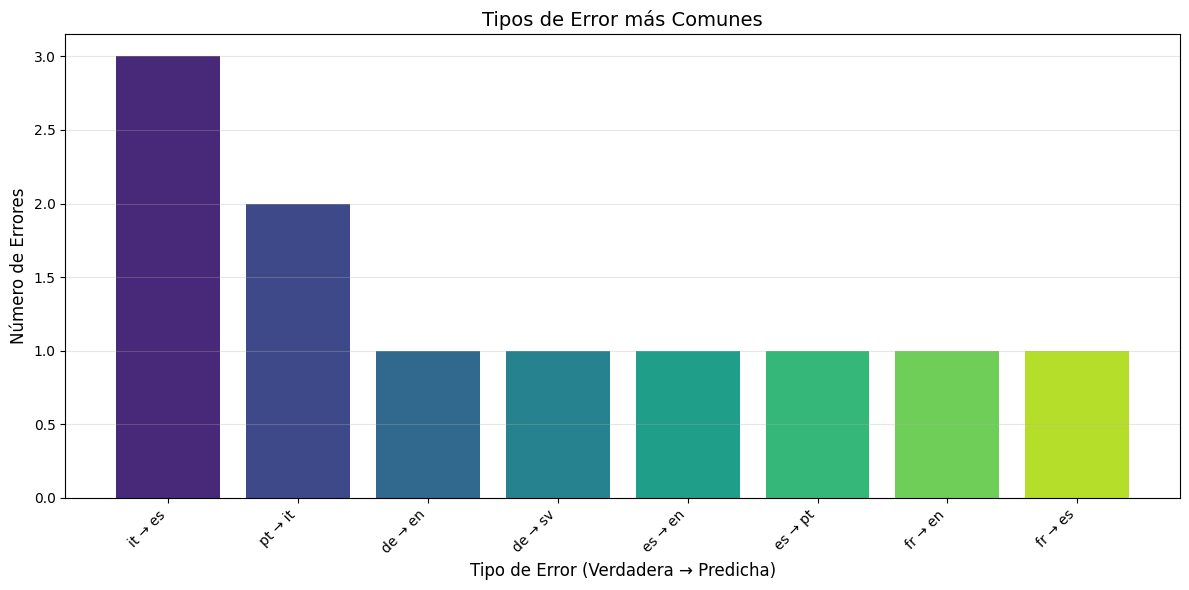


Ejemplos de los errores más comunes:

Error: it clasificado como es (3 casos)

Ejemplo 1:
al n



Ejemplo 2:
e una trappola


Error: pt clasificado como it (2 casos)

Ejemplo 1:
o parlamento manifesta a sua concordância sextafeira presidente



Ejemplo 2:
evans robert pse


Error: de clasificado como en (1 casos)

Ejemplo 1:
herr kreissldörfler beispielsweise hat in englisch von long term financing for long term projects gesprochen



####################################################################################################
EVALUACIÓN COMPLETA DEL CLASIFICADOR: Regresión Logística
####################################################################################################

EVALUACIÓN EXHAUSTIVA: Regresión Logística
Tiempo de predicción para 12000 muestras: 0.0028 segundos

Métricas globales:
Accuracy: 0.9962
Macro-Precision: 0.9963
Macro-Recall: 0.9963
Macro-F1: 0.9963
Weighted-Precision: 0.9963
Weighted-Recall: 0.9962
Weighted-F1: 0.9963

Informe de clasificación de

C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='precision', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='recall', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='f1-score', data=df_

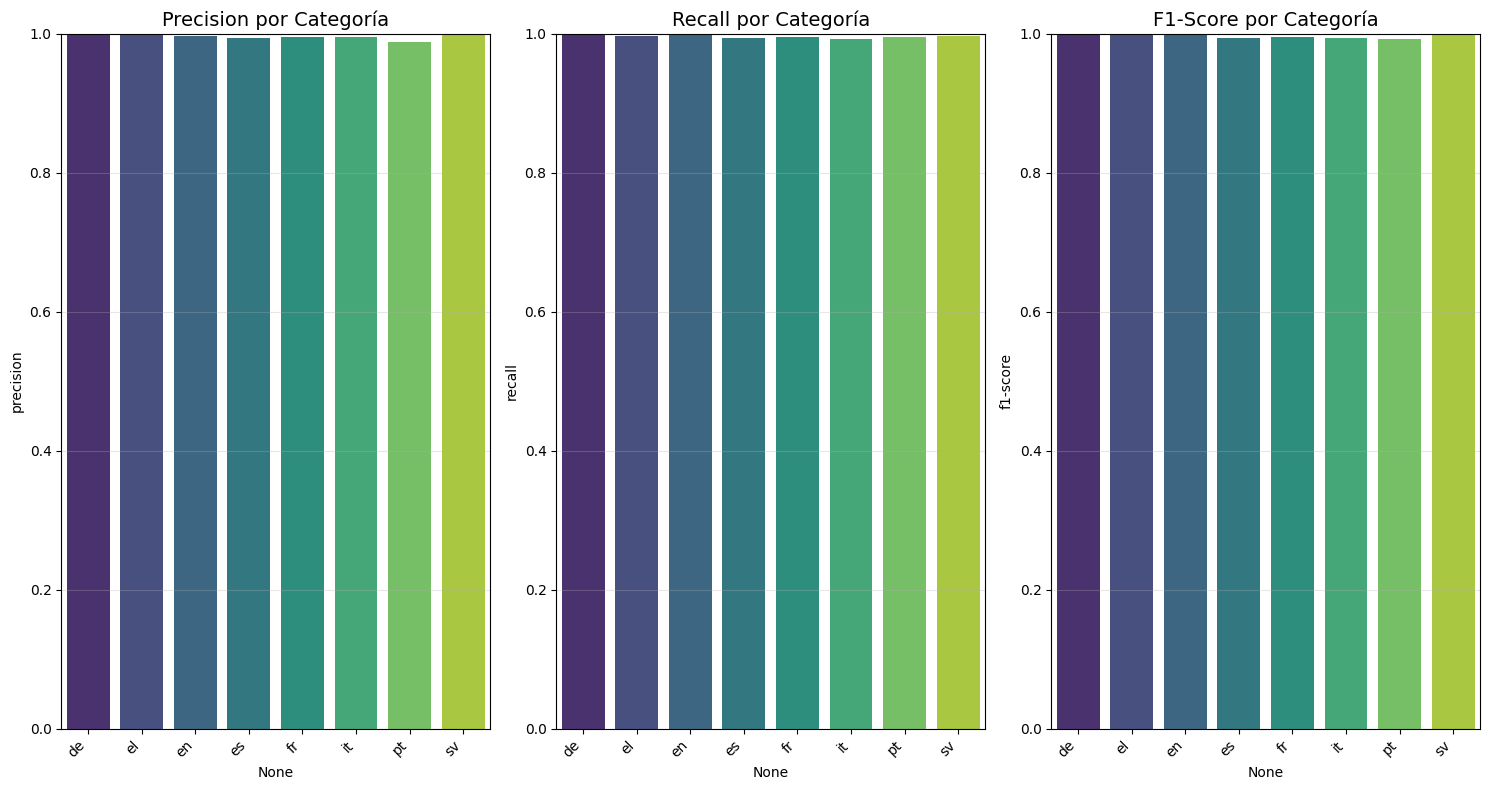


Matriz de confusión sin normalizar:


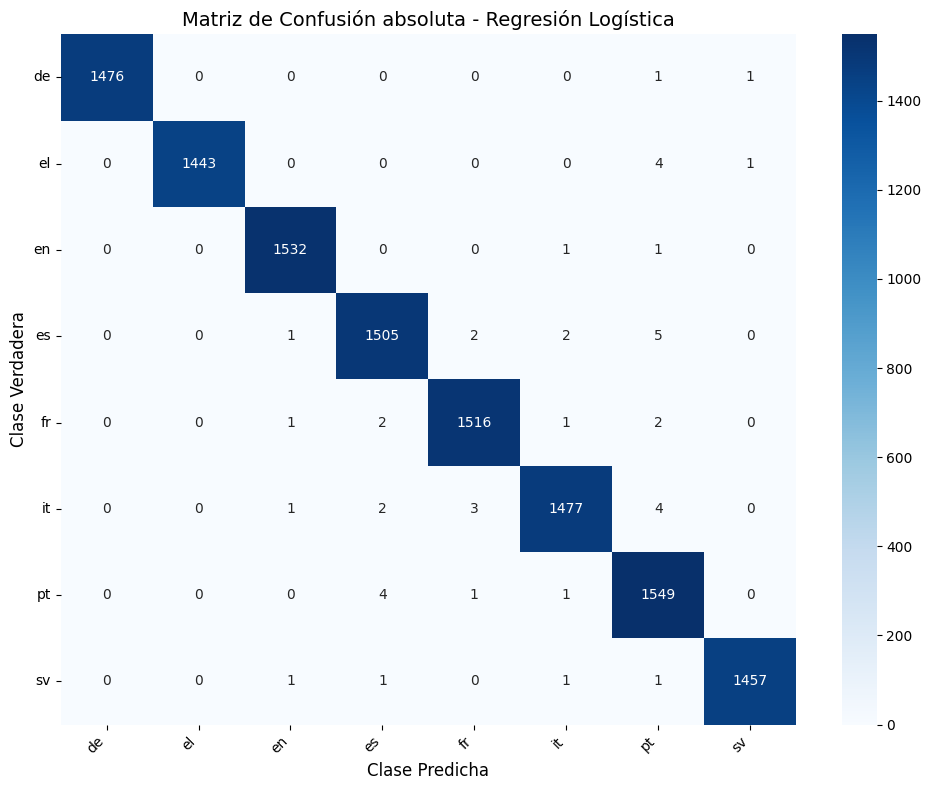


Matriz de confusión normalizada por filas (clase verdadera):


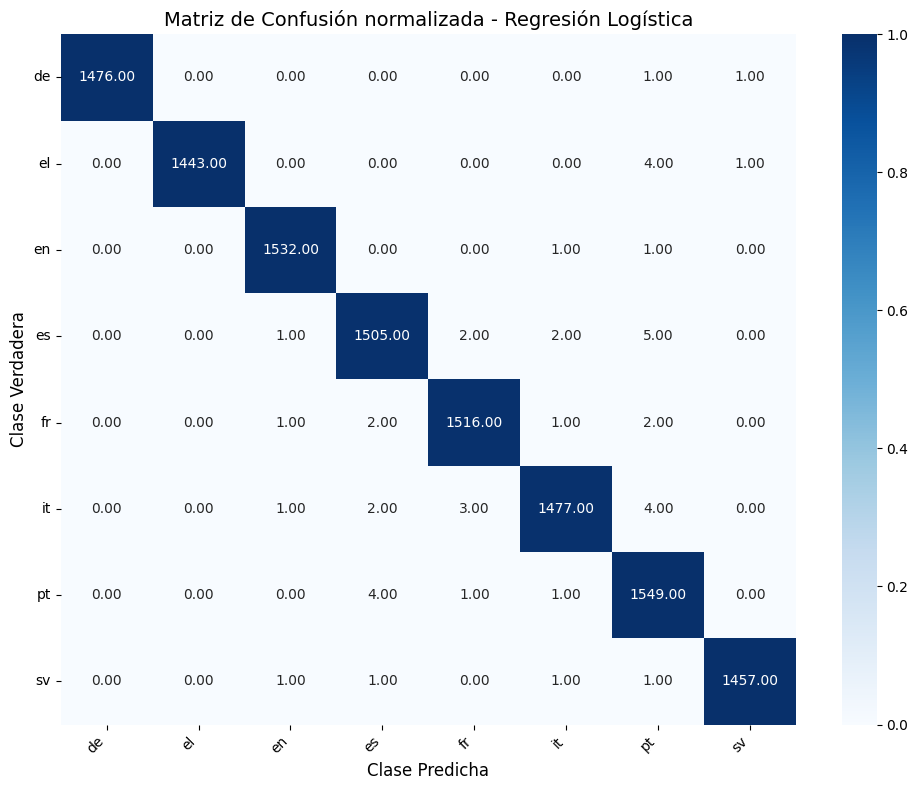


VALIDACIÓN CRUZADA: Regresión Logística
Validación cruzada completada en 4.70 segundos

Resultados por métrica:
accuracy: 0.9962 (±0.0004)
precision_macro: 0.9962 (±0.0004)
recall_macro: 0.9962 (±0.0004)
f1_macro: 0.9962 (±0.0004)
precision_weighted: 0.9962 (±0.0004)
recall_weighted: 0.9962 (±0.0004)
f1_weighted: 0.9962 (±0.0004)


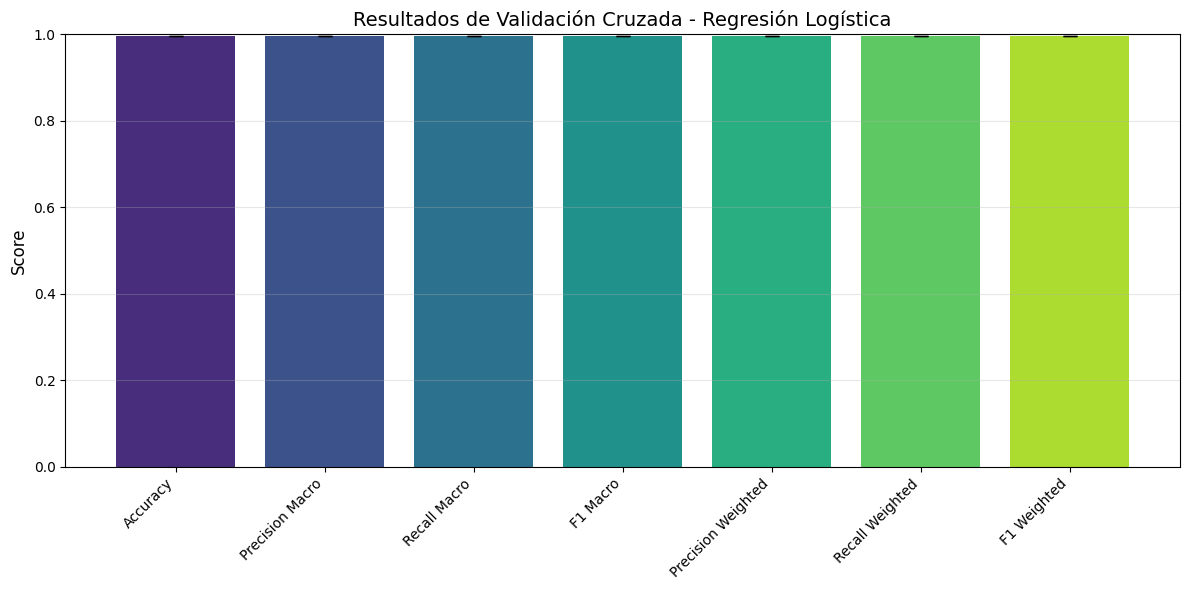


CURVA DE APRENDIZAJE: Regresión Logística
Curva de aprendizaje calculada en 19.52 segundos

Scores por tamaño de entrenamiento:
| % Datos | Muestras | Train Score | Test Score |
|---------|----------|-------------|------------|
|  10.0% |     4480 | 0.9993 ± 0.0000 | 0.9909 ± 0.0009 |
|  20.0% |     8960 | 0.9992 ± 0.0002 | 0.9935 ± 0.0007 |
|  30.0% |    13440 | 0.9993 ± 0.0001 | 0.9944 ± 0.0005 |
|  40.0% |    17920 | 0.9993 ± 0.0001 | 0.9949 ± 0.0004 |
|  50.0% |    22400 | 0.9993 ± 0.0001 | 0.9953 ± 0.0004 |
|  60.0% |    26880 | 0.9993 ± 0.0001 | 0.9956 ± 0.0004 |
|  70.0% |    31360 | 0.9994 ± 0.0001 | 0.9958 ± 0.0004 |
|  80.0% |    35840 | 0.9994 ± 0.0001 | 0.9960 ± 0.0004 |
|  90.0% |    40320 | 0.9993 ± 0.0001 | 0.9963 ± 0.0003 |
| 100.0% |    44800 | 0.9994 ± 0.0001 | 0.9962 ± 0.0004 |


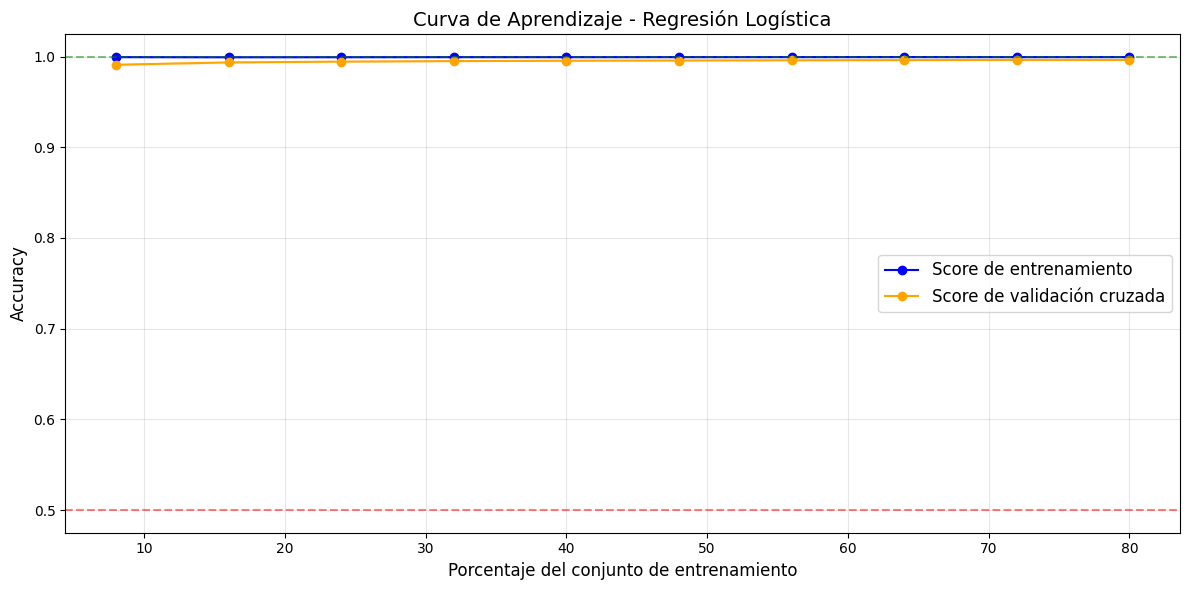


ANÁLISIS DE ERRORES: Regresión Logística
Tasa de error global: 45/12000 (0.38%)

Análisis de errores por pares de clases:
   Clase_Verdadera Clase_Predicha  Conteo
9               es             pt       5
2               el             pt       4
18              pt             es       4
17              it             pt       4
16              it             fr       3
7               es             fr       2
8               es             it       2
11              fr             es       2
13              fr             pt       2
15              it             es       2
0               de             pt       1
23              sv             it       1
22              sv             es       1
21              sv             en       1
20              pt             it       1
19              pt             fr       1
12              fr             it       1
14              it             en       1
1               de             sv       1
10              fr             en    

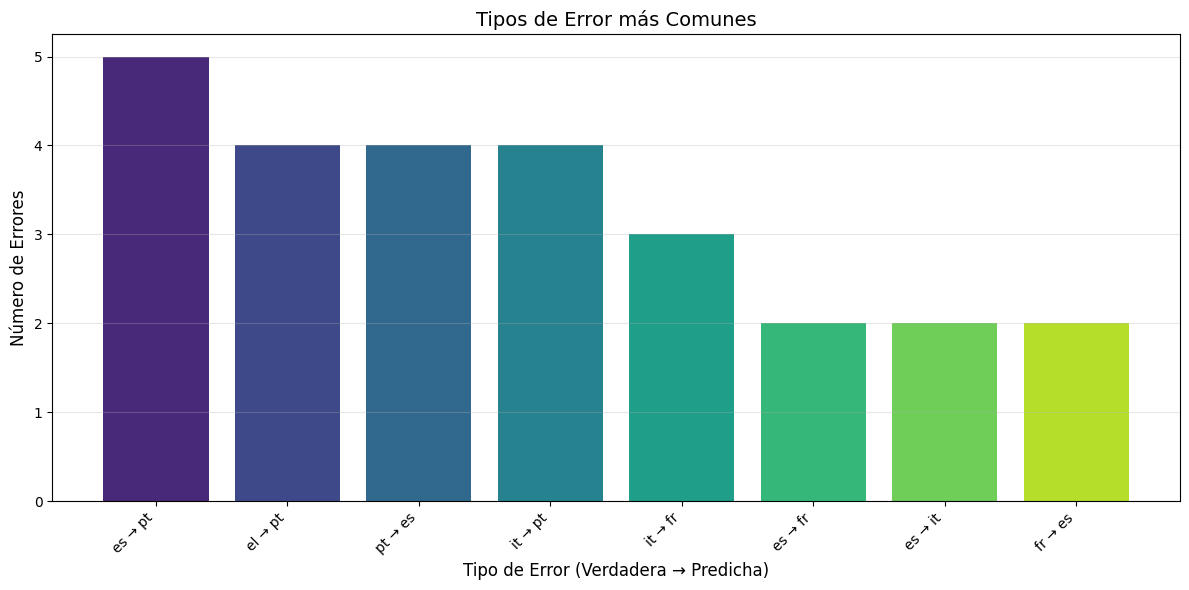


Ejemplos de los errores más comunes:

Error: es clasificado como pt (5 casos)

Ejemplo 1:
lo menciono como aspecto importante de esta iniciativa



Ejemplo 2:
esta jurisprudencia sigue siendo válida y nada justifica que vuelva a ser cuestionada


Error: el clasificado como pt (4 casos)

Ejemplo 1:
ο ρυπαίνων πληρώνει



Ejemplo 2:
η αίτηση υποβλήθηκε εκπρόθεσμα


Error: pt clasificado como es (4 casos)

Ejemplo 1:
mas há que saber como enfrentá­los como conduzi­los



Ejemplo 2:
está totalmente previsto no regimento



####################################################################################################
EVALUACIÓN COMPLETA DEL CLASIFICADOR: SVM Lineal
####################################################################################################

EVALUACIÓN EXHAUSTIVA: SVM Lineal
Tiempo de predicción para 12000 muestras: 0.0454 segundos

Métricas globales:
Accuracy: 0.9972
Macro-Precision: 0.9972
Macro-Recall: 0.9972
Macro-F1: 0.9972
Weighted-Precision: 0.9972
Weig

C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='precision', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='recall', data=df_por_categoria, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_8420\3919993621.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_por_categoria.index, y='f1-score', data=df_

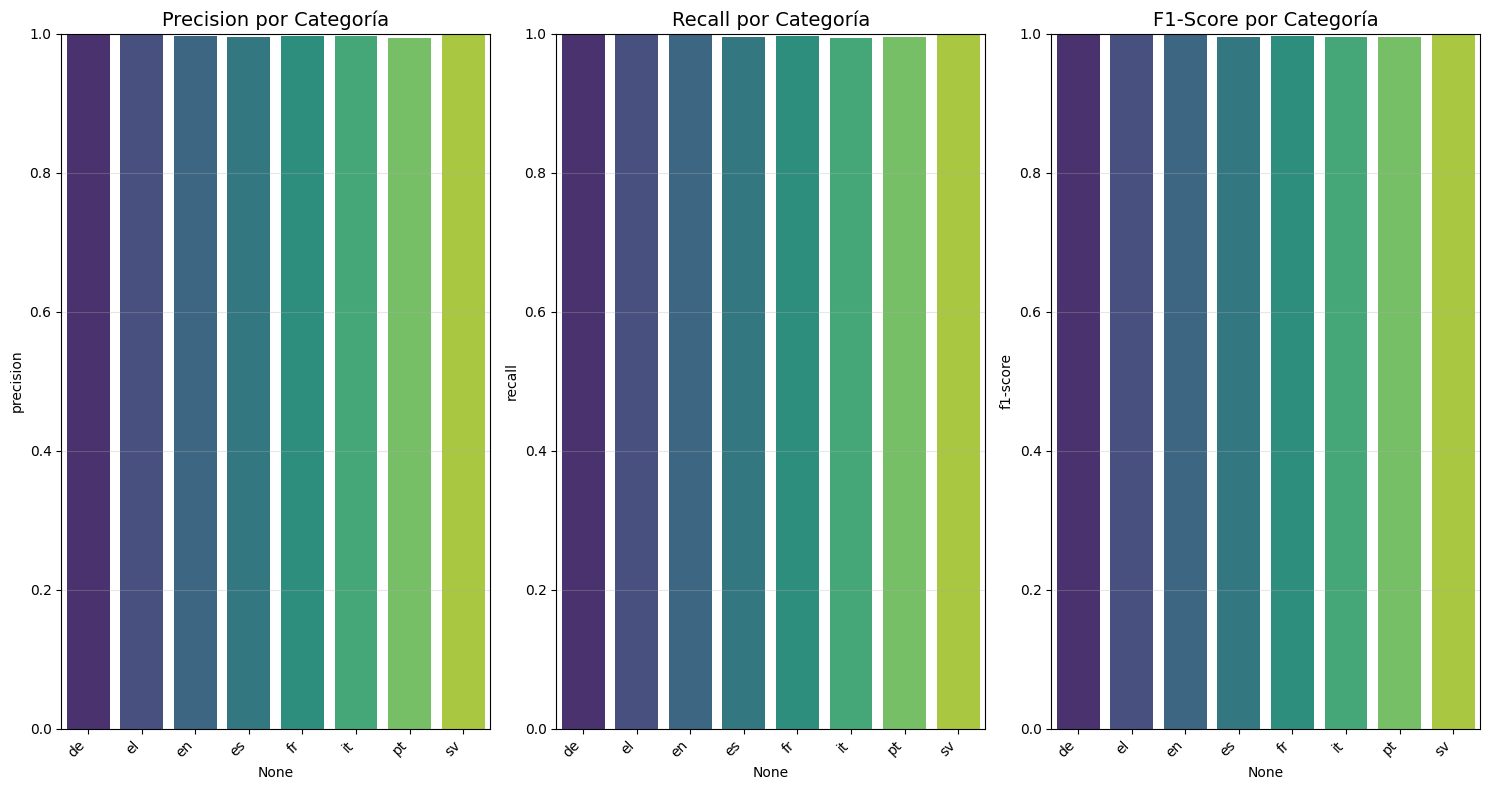


Matriz de confusión sin normalizar:


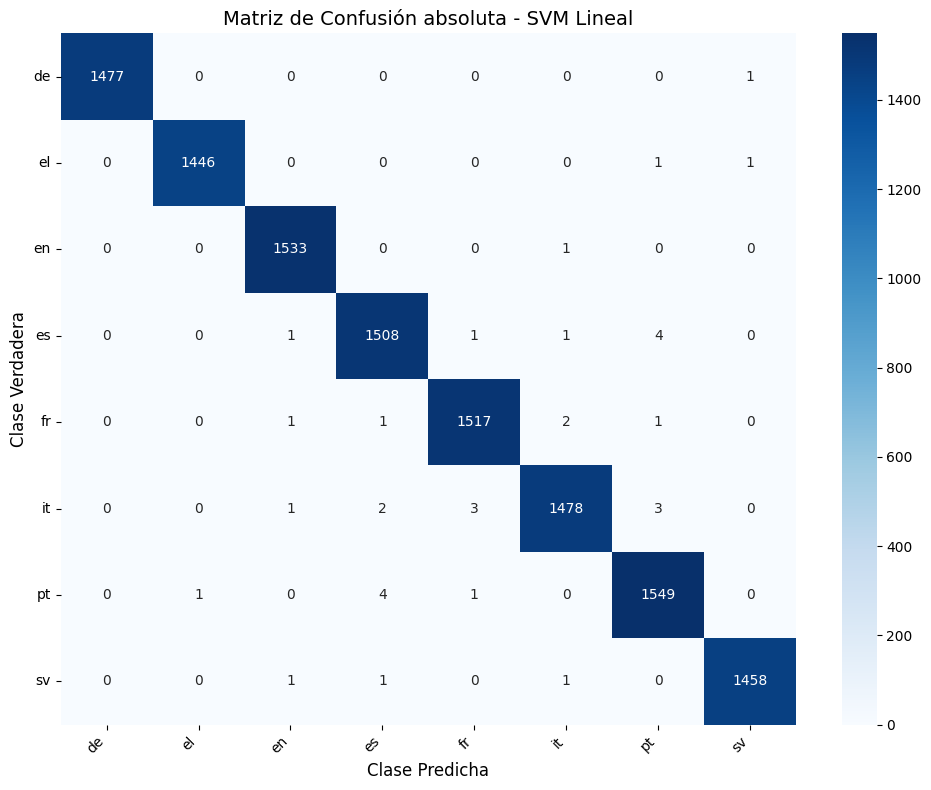


Matriz de confusión normalizada por filas (clase verdadera):


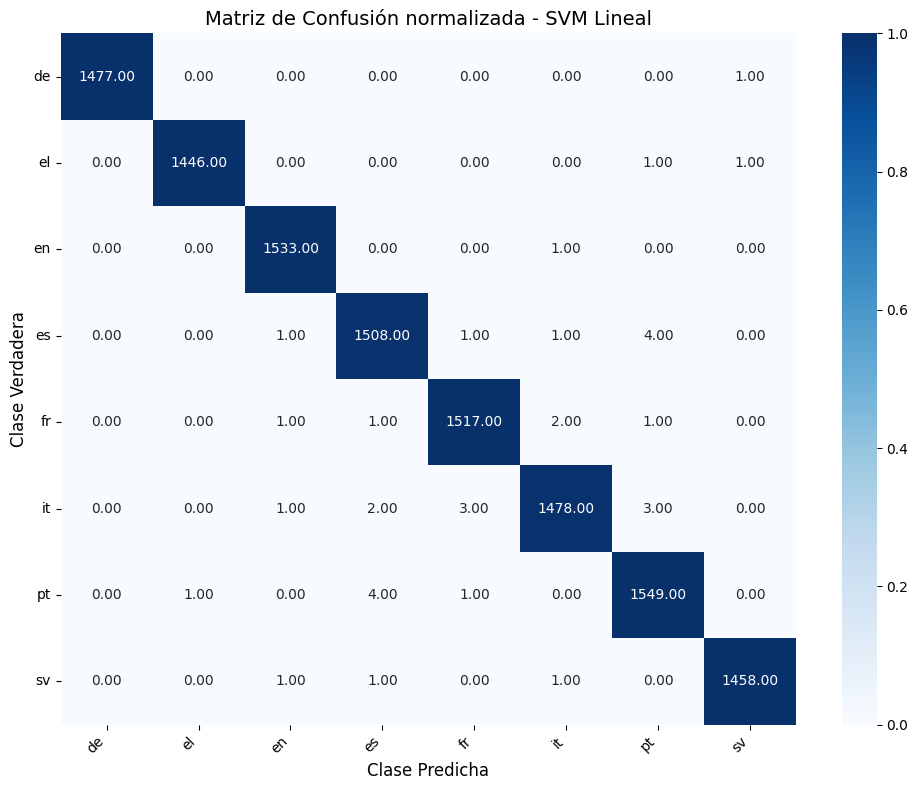


VALIDACIÓN CRUZADA: SVM Lineal
Validación cruzada completada en 11.12 segundos

Resultados por métrica:
accuracy: 0.9969 (±0.0004)
precision_macro: 0.9969 (±0.0004)
recall_macro: 0.9969 (±0.0004)
f1_macro: 0.9969 (±0.0004)
precision_weighted: 0.9969 (±0.0004)
recall_weighted: 0.9969 (±0.0004)
f1_weighted: 0.9969 (±0.0004)


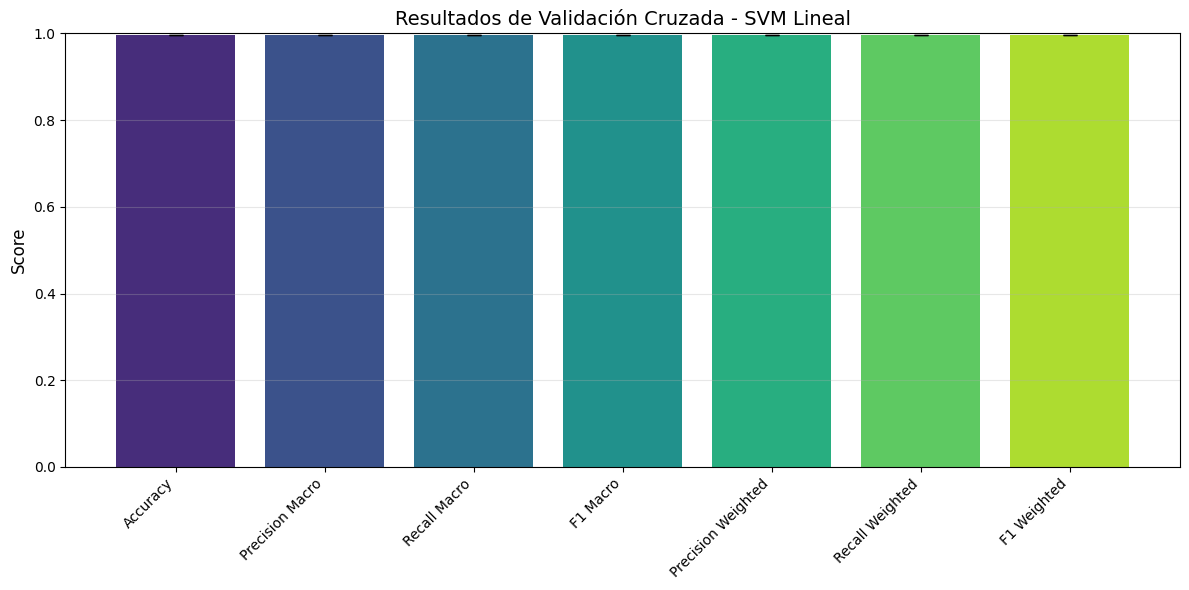


CURVA DE APRENDIZAJE: SVM Lineal
Curva de aprendizaje calculada en 33.87 segundos

Scores por tamaño de entrenamiento:
| % Datos | Muestras | Train Score | Test Score |
|---------|----------|-------------|------------|
|  10.0% |     4480 | 0.9993 ± 0.0000 | 0.9919 ± 0.0007 |
|  20.0% |     8960 | 0.9992 ± 0.0002 | 0.9944 ± 0.0006 |
|  30.0% |    13440 | 0.9994 ± 0.0001 | 0.9952 ± 0.0004 |
|  40.0% |    17920 | 0.9994 ± 0.0001 | 0.9956 ± 0.0002 |
|  50.0% |    22400 | 0.9994 ± 0.0001 | 0.9961 ± 0.0003 |
|  60.0% |    26880 | 0.9995 ± 0.0001 | 0.9962 ± 0.0004 |
|  70.0% |    31360 | 0.9995 ± 0.0001 | 0.9964 ± 0.0004 |
|  80.0% |    35840 | 0.9994 ± 0.0001 | 0.9966 ± 0.0005 |
|  90.0% |    40320 | 0.9994 ± 0.0001 | 0.9967 ± 0.0003 |
| 100.0% |    44800 | 0.9994 ± 0.0001 | 0.9969 ± 0.0004 |


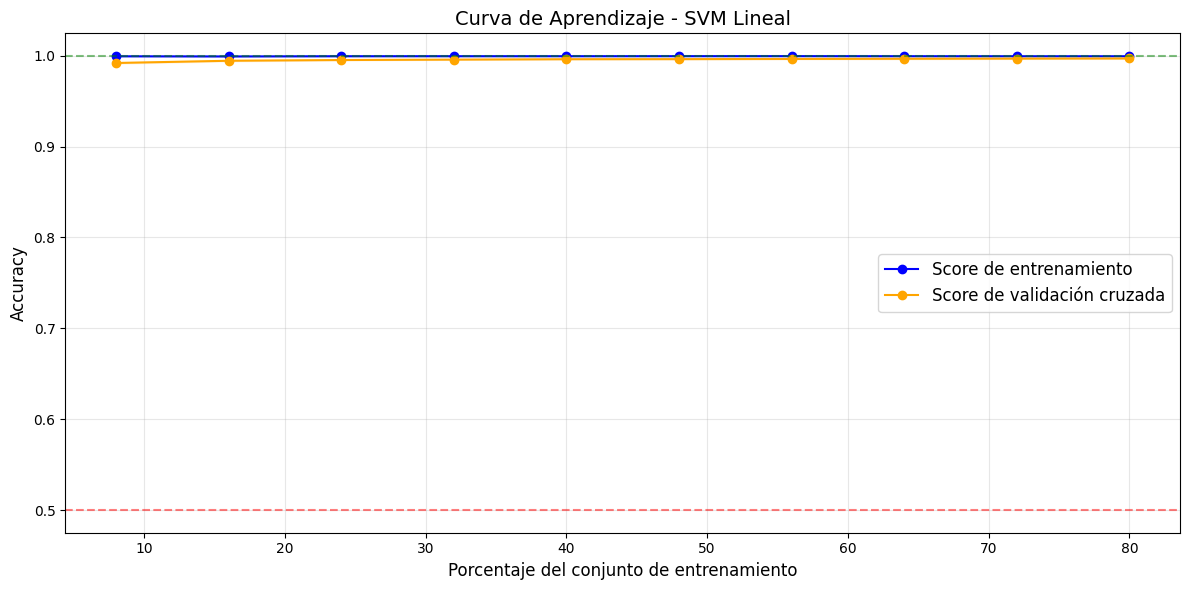


ANÁLISIS DE ERRORES: SVM Lineal
Tasa de error global: 34/12000 (0.28%)

Análisis de errores por pares de clases:
   Clase_Verdadera Clase_Predicha  Conteo
17              pt             es       4
7               es             pt       4
15              it             pt       3
14              it             fr       3
10              fr             it       2
13              it             es       2
0               de             sv       1
12              it             en       1
20              sv             es       1
19              sv             en       1
18              pt             fr       1
16              pt             el       1
11              fr             pt       1
1               el             pt       1
9               fr             es       1
8               fr             en       1
6               es             it       1
5               es             fr       1
4               es             en       1
3               en             it       1
2   

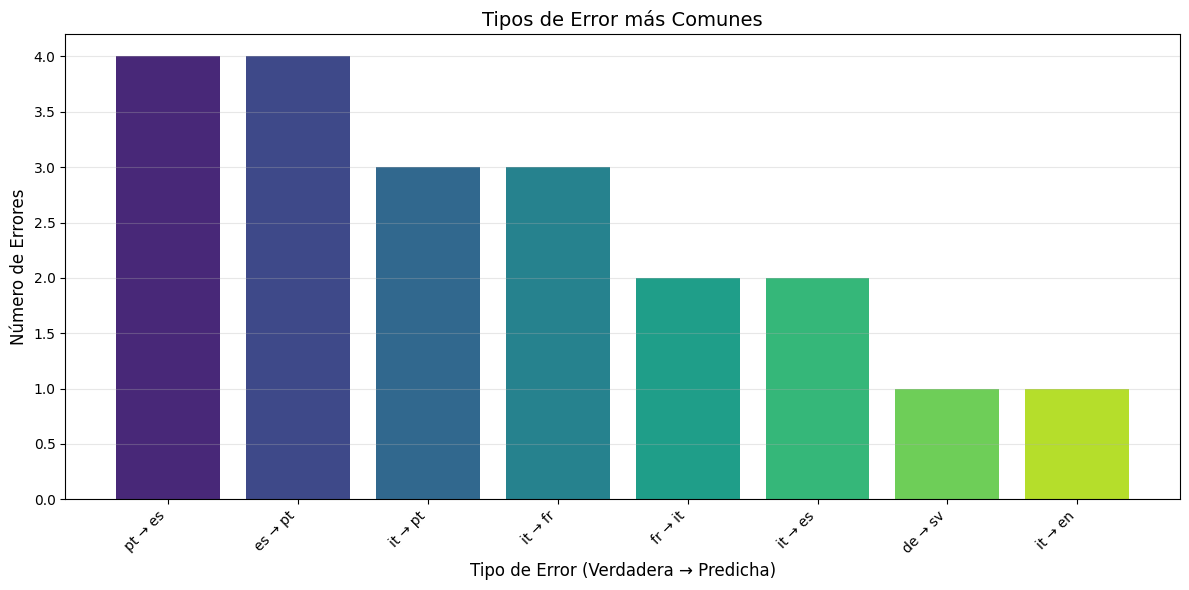


Ejemplos de los errores más comunes:

Error: pt clasificado como es (4 casos)

Ejemplo 1:
mas há que saber como enfrentá­los como conduzi­los



Ejemplo 2:
está totalmente previsto no regimento


Error: es clasificado como pt (4 casos)

Ejemplo 1:
lo menciono como aspecto importante de esta iniciativa



Ejemplo 2:
¡subsisten lagunas


Error: it clasificado como pt (3 casos)

Ejemplo 1:
lho trovato perfetto



Ejemplo 2:
com c cod




In [23]:
# Código para ejecutar la evaluación de todos los clasificadores
def ejecutar_evaluacion_completa():
    """
    Ejecuta la evaluación exhaustiva de todos los clasificadores.
    """
    # Diccionario para almacenar todos los resultados
    resultados_evaluacion = {}
    
    # Evaluamos cada clasificador
    for nombre, resultado in resultados_clasificadores.items():
        modelo = resultado['modelo']
        
        print(f"\n{'#'*100}\nEVALUACIÓN COMPLETA DEL CLASIFICADOR: {nombre}\n{'#'*100}")
        
        # 1. Evaluación básica
        metricas = evaluar_clasificador_completo(modelo, X_train_tfidf, y_train, X_test_tfidf, y_test, nombre)
        
        # 2. Visualizamos la matriz de confusión
        print("\nMatriz de confusión sin normalizar:")
        visualizar_matriz_confusion(metricas['matriz_confusion'], sorted(np.unique(y_train)), nombre, normalizar=False)
        
        print("\nMatriz de confusión normalizada por filas (clase verdadera):")
        visualizar_matriz_confusion(metricas['matriz_confusion'], sorted(np.unique(y_train)), nombre, normalizar=True)
        
        # 3. Realizamos validación cruzada
        scores_cv = realizar_validacion_cruzada(modelo, X_train_tfidf, y_train, cv=5, nombre_modelo=nombre)
        
        # 4. Generamos curva de aprendizaje
        (train_sizes, train_scores, 
         test_scores) = generar_curva_aprendizaje(modelo, X_train_tfidf, y_train, nombre, cv=5)
        
        # 5. Realizamos análisis de errores
        df_errores = analizar_errores_clasificador(y_test, metricas['y_pred'], 
                                                  X_test, nombre, n_ejemplos=2)
        
        # Guardamos todos los resultados
        resultados_evaluacion[nombre] = {
            'metricas_test': metricas,
            'scores_cv': scores_cv,
            'curva_aprendizaje': {
                'train_sizes': train_sizes,
                'train_scores': train_scores,
                'test_scores': test_scores
            },
            'analisis_errores': df_errores
        }
    
    return resultados_evaluacion

# Ejecutamos la evaluación completa
resultados_evaluacion = ejecutar_evaluacion_completa()

### Análisis de errores de Naive Bayes Multinomial

Puesto que este modelo es el que mejor desempeño ha tenido, tanto en capacidad de predicción como en tiempo de entrenamiento, considero que es conveniente ver cuáles son las frases que no ha clasificado correctamente

In [24]:
pd.set_option('display.max_colwidth', None)

df_errores = resultados_evaluacion['Naive Bayes Multinomial']['analisis_errores']

print("Todos los errores de Naive Bayes Multinomial:")
print("")

for id in CLASES:
        print("Clase verdadera:",id,f"({IDIOMAS[id]})")
        df_id = df_errores[df_errores['Clase_Verdadera'] == id]
        display(df_id)

Todos los errores de Naive Bayes Multinomial:

Clase verdadera: de (alemán)


,Texto,Clase_Verdadera,Clase_Predicha
1,herr monti,de,sv
4,herr kreissldörfler beispielsweise hat in englisch von long term financing for long term projects gesprochen,de,en


Clase verdadera: el (griego)


,Texto,Clase_Verdadera,Clase_Predicha


Clase verdadera: es (español)


,Texto,Clase_Verdadera,Clase_Predicha
2,no not this time either,es,en
12,la etnia de base religiosa la santa alianza de adam smith y calvino,es,pt


Clase verdadera: fr (francés)


,Texto,Clase_Verdadera,Clase_Predicha
7,je me contenterai de leur dire you can t have it all,fr,en
14,que voientils,fr,es


Clase verdadera: it (italiano)


,Texto,Clase_Verdadera,Clase_Predicha
0,lho trovato perfetto,it,el
6,com c cod,it,pt
8,where is the beef,it,en
9,al n,it,es
10,e le donne,it,fr
13,e una trappola,it,es
16,al n,it,es


Clase verdadera: pt (portugués)


,Texto,Clase_Verdadera,Clase_Predicha
3,monsieur prodi préparez votre défense cest la défense de leurope,pt,fr
5,o parlamento manifesta a sua concordância sextafeira presidente,pt,it
15,evans robert pse,pt,it
17,permitam­me que pergunte quousque tandem ­ noiz arte,pt,es


Clase verdadera: sv (sueco)


,Texto,Clase_Verdadera,Clase_Predicha
11,vi lever i ideaåldern the internet digital electronic age,sv,en


Clase verdadera: en (inglés)


,Texto,Clase_Verdadera,Clase_Predicha


Se puede ver que los errores son mayormente cometidos debido a que el texto contiene palabras pertenecientes a otro idioma diferente al de su clase, es el caso de las frases con índice 4, 7, 8, 10 u 11. Por otra parte, también existen frases con muy pocas palabras y sin significado que tampoco han sido clasificadas correctamente: la 6, la 9 o la 15.

A continuación, vamos a ver la distribución de la longitud de las frases clasificadas incorrectamente.

In [25]:
longitud_errores = np.array([len(df_errores['Texto'][i].split()) for i in range(len(df_errores))])
df_errores['Longitud'] = longitud_errores

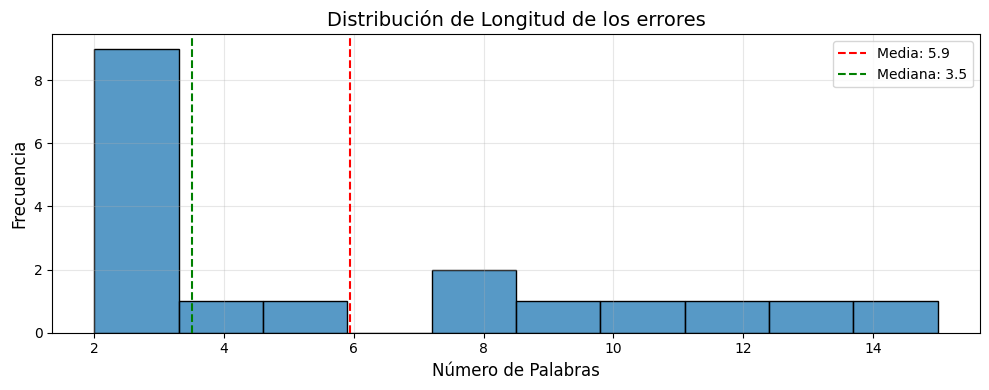

In [26]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_errores, x='Longitud', bins=10, kde=False)
plt.axvline(df_errores['Longitud'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_errores['Longitud'].mean():.1f}')
plt.axvline(df_errores['Longitud'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_errores['Longitud'].median():.1f}')
plt.title('Distribución de Longitud de los errores', fontsize=14)
plt.xlabel('Número de Palabras', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Vemos que predominan las frases con muy pocas palabras (entre 2 y 3). Esto contrasta con la distribución de todo el dataset, donde estas frases con muy poco cuantiosas. 

### Implementación RNN

A continuación se implementará un modelo RNN. Previamente, se prepará la codificación secuencial, necesaria para este tipo de modelos. También se aprovechará para el modelo LSTM Bidireccional, implementado en segundo lugar.

In [27]:
# Función para realizar tokenización y padding
def preprocesar_secuencias(textos_train, textos_val, textos_test, max_palabras=10000, max_longitud=None):
    """
    Preprocesa textos para modelos recurrentes mediante tokenización y padding.
    
    Args:
        textos_train: Lista de textos de entrenamiento
        textos_val: Lista de textos de validación
        textos_test: Lista de textos de prueba
        max_palabras: Tamaño máximo del vocabulario
        max_longitud: Longitud máxima de las secuencias (si es None, se calcula automáticamente)
        
    Returns:
        Datos preprocesados y tokenizador
    """
    # Inicializamos el tokenizador
    tokenizer = Tokenizer(num_words=max_palabras, oov_token="<OOV>")
    
    # Ajustamos el tokenizador en los datos de entrenamiento
    tokenizer.fit_on_texts(textos_train)
    
    # Convertimos textos a secuencias
    secuencias_train = tokenizer.texts_to_sequences(textos_train)
    secuencias_val = tokenizer.texts_to_sequences(textos_val)
    secuencias_test = tokenizer.texts_to_sequences(textos_test)
    
    # Determinamos longitud máxima si no se especifica
    if max_longitud is None:
        longitudes = [len(seq) for seq in secuencias_train]
        max_longitud = int(np.percentile(longitudes, 95))  # Usamos el percentil 95 para evitar outliers
    
    # Realizamos padding
    X_train = pad_sequences(secuencias_train, maxlen=max_longitud, padding='post')
    X_val = pad_sequences(secuencias_val, maxlen=max_longitud, padding='post')
    X_test = pad_sequences(secuencias_test, maxlen=max_longitud, padding='post')
    
    # Información sobre el vocabulario
    vocab_size = min(max_palabras, len(tokenizer.word_index) + 1)
    palabra_a_indice = tokenizer.word_index
    indice_a_palabra = {v: k for k, v in palabra_a_indice.items()}
    
    print(f"Preprocesamiento completado:")
    print(f"- Tamaño del vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_longitud} tokens")
    print(f"- Ejemplos de tokenización:")
    
    # Mostramos ejemplos
    for i in range(min(10, len(textos_train))):
        texto = textos_train[i]
        secuencia = secuencias_train[i]
        tokens = [indice_a_palabra.get(idx, "<PAD>") if idx != 0 else "<PAD>" for idx in X_train[i]]
        
        print(f"  Texto: '{texto}'")
        print(f"  Secuencia: {secuencia}")
        print(f"  Con padding: {X_train[i]}")
        print(f"  Tokens: {tokens}\n")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'tokenizer': tokenizer,
        'vocab_size': vocab_size,
        'max_length': max_longitud,
        'word_index': palabra_a_indice,
        'index_word': indice_a_palabra
    }


In [28]:
# Realizamos el preprocesamiento de secuencias
print("Preprocesando datos para redes recurrentes...")
secuencias_data = preprocesar_secuencias(
    X_train,
    X_val,
    X_test,
    max_palabras=10000
)


Preprocesando datos para redes recurrentes...
Preprocesamiento completado:
- Tamaño del vocabulario: 10000 palabras
- Longitud máxima de secuencia: 15 tokens
- Ejemplos de tokenización:
  Texto: 'nous devrons encore en discuter'
  Secuencia: [38, 9539, 676, 7, 8389]
  Con padding: [  38 9539  676    7 8389    0    0    0    0    0    0    0    0    0
    0]
  Tokens: ['nous', 'devrons', 'encore', 'en', 'discuter', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

  Texto: 'die küstenregionen mit ihrer seewirtschaft weisen ein großes entwicklungspotential auf'
  Secuencia: [10, 1, 209, 1662, 1, 1, 161, 9540, 1, 151]
  Con padding: [  10    1  209 1662    1    1  161 9540    1  151    0    0    0    0
    0]
  Tokens: ['die', '<OOV>', 'mit', 'ihrer', '<OOV>', '<OOV>', 'ein', 'großes', '<OOV>', 'auf', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

  Texto: 'exorto a assembleia a apoiar estas alterações'
  Secuencia: [1, 3, 2152, 3, 4043, 357, 621]
 

In [ ]:
# Preparamos los datos para entrenar modelos recurrentes
def preparar_datos_recurrentes():
    """
    Prepara los datos para el entrenamiento de modelos recurrentes.
    
    Returns:
        Diccionario con datos y configuración
    """
    # Obtenemos secuencias (X) y etiquetas (y)
    X_train = secuencias_data['X_train']
    X_val = secuencias_data['X_val']
    X_test = secuencias_data['X_test']
    
    # Obtenemos etiquetas
    y_train_idx = np.array([CLASES.tolist().index(c) for c in y_train])
    y_val_idx = np.array([CLASES.tolist().index(c) for c in y_val])
    y_test_idx = np.array([CLASES.tolist().index(c) for c in y_test])

    # Parámetros para la arquitectura
    vocab_size = secuencias_data['vocab_size']
    max_length = secuencias_data['max_length']
    embedding_dim = 100  # Dimensión de los embeddings
    
    print(f"Datos recurrentes preparados:")
    print(f"- X_train: {X_train.shape}")
    print(f"- X_val: {X_val.shape}")
    print(f"- X_test: {X_test.shape}")
    print(f"- Vocabulario: {vocab_size} palabras")
    print(f"- Longitud máxima de secuencia: {max_length}")
    print(f"- Dimensión de embeddings: {embedding_dim}")
    print(f"- Número de clases (idiomas): {len(CLASES)}")
    
    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train_idx,
        'y_val': y_val_idx,
        'y_test': y_test_idx,
        'vocab_size': vocab_size,
        'max_length': max_length,
        'embedding_dim': embedding_dim,
        'num_classes': len(CLASES),
        'idiomas': CLASES,
        'tokenizer': secuencias_data['tokenizer']
    }

In [30]:
# Preparamos los datos
datos_recurrentes = preparar_datos_recurrentes()

Datos recurrentes preparados:
- X_train: (56000, 15)
- X_val: (12000, 15)
- X_test: (12000, 15)
- Vocabulario: 10000 palabras
- Longitud máxima de secuencia: 15
- Dimensión de embeddings: 100
- Número de clases (idiomas): 8


In [31]:
# Función para crear modelo RNN simple
def crear_modelo_rnn_simple(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo RNN simple para detección de intenciones.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (intenciones)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
    ))
    
    # Capa RNN simple
    model.add(SimpleRNN(
        units=64,
        activation='tanh',
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
    ))
    
    # Capa de dropout
    model.add(Dropout(dropout_rate))
    
    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostramos el resumen
    model.summary()
    
    return model

In [32]:
# Creamos el modelo RNN simple
modelo_rnn_simple = crear_modelo_rnn_simple(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Función para entrenar modelo
def entrenar_modelo_recurrente(modelo, datos, nombre_modelo, epochs=15, batch_size=32):
    """
    Entrena un modelo recurrente con early stopping y reducción de learning rate.
    
    Args:
        modelo: Modelo a entrenar
        datos: Diccionario con datos de entrenamiento y validación
        nombre_modelo: Nombre para guardar el modelo
        epochs: Número máximo de épocas
        batch_size: Tamaño del batch
        
    Returns:
        Historia del entrenamiento
    """
    # Callbacks
    callbacks = [
        # Early stopping para detener cuando no hay mejora
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reducción de learning rate cuando se estanca
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=0.00001
        ),
    ]
    
    # Entrenamos el modelo
    history = modelo.fit(
        datos['X_train'], datos['y_train'],
        validation_data=(datos['X_val'], datos['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )
    
    return history

In [34]:
# Entrenamos el modelo RNN simple
print("\nEntrenando modelo RNN simple:")
history_rnn_simple = entrenar_modelo_recurrente(
    modelo_rnn_simple,
    datos_recurrentes,
    "modelo_rnn_simple"
)


Entrenando modelo RNN simple:
Epoch 1/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2195 - loss: 1.7845 - val_accuracy: 0.7125 - val_loss: 0.8954 - learning_rate: 0.0010
Epoch 2/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7326 - loss: 0.8630 - val_accuracy: 0.8535 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 3/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8507 - loss: 0.5378 - val_accuracy: 0.8674 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 4/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8689 - loss: 0.4541 - val_accuracy: 0.8658 - val_loss: 0.4138 - learning_rate: 0.0010
Epoch 5/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8766 - loss: 0.4000 - val_accuracy: 0.8788 - val_loss: 0.3903 - learning_rate: 0.0010
Epoch 6/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8815 - loss: 0.3770 - val_accuracy: 0.8827 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 7/15
1750/1750 ━━━━━━━━━━━━━━━━━━

In [35]:
# Función para visualizar el entrenamiento
def visualizar_entrenamiento_recurrente(history, title="Entrenamiento del Modelo"):
    """
    Visualiza la evolución del entrenamiento del modelo.
    
    Args:
        history: Historial del entrenamiento
        title: Título del gráfico
    """
    # Extraemos métricas
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    # Configuramos la figura
    plt.figure(figsize=(14, 5))
    
    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'bo-', label='Precisión entrenamiento')
    plt.plot(epochs_range, val_acc, 'ro-', label='Precisión validación')
    plt.title('Precisión de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Precisión', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'bo-', label='Pérdida entrenamiento')
    plt.plot(epochs_range, val_loss, 'ro-', label='Pérdida validación')
    plt.title('Pérdida de Entrenamiento y Validación', fontsize=12)
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Pérdida', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    
    # Métricas finales
    final_epoch = len(acc)
    print(f"Métricas finales ({final_epoch} épocas):")
    print(f"  Precisión entrenamiento: {acc[-1]:.4f}")
    print(f"  Precisión validación: {val_acc[-1]:.4f}")
    print(f"  Pérdida entrenamiento: {loss[-1]:.4f}")
    print(f"  Pérdida validación: {val_loss[-1]:.4f}")
    
    # Mejor época
    best_epoch = np.argmax(val_acc) + 1
    print(f"\nMejor rendimiento (época {best_epoch}):")
    print(f"  Precisión validación: {max(val_acc):.4f}")
    print(f"  Pérdida validación: {val_loss[best_epoch-1]:.4f}")
    
    # Análisis de sobreajuste
    overfit_gap = acc[-1] - val_acc[-1]
    print(f"\nBrecha de entrenamiento-validación: {overfit_gap:.4f}")
    if overfit_gap > 0.1:
        print("⚠ Posible sobreajuste detectado. Considerar mayor regularización.")
    else:
        print("✓ No hay señales significativas de sobreajuste.")

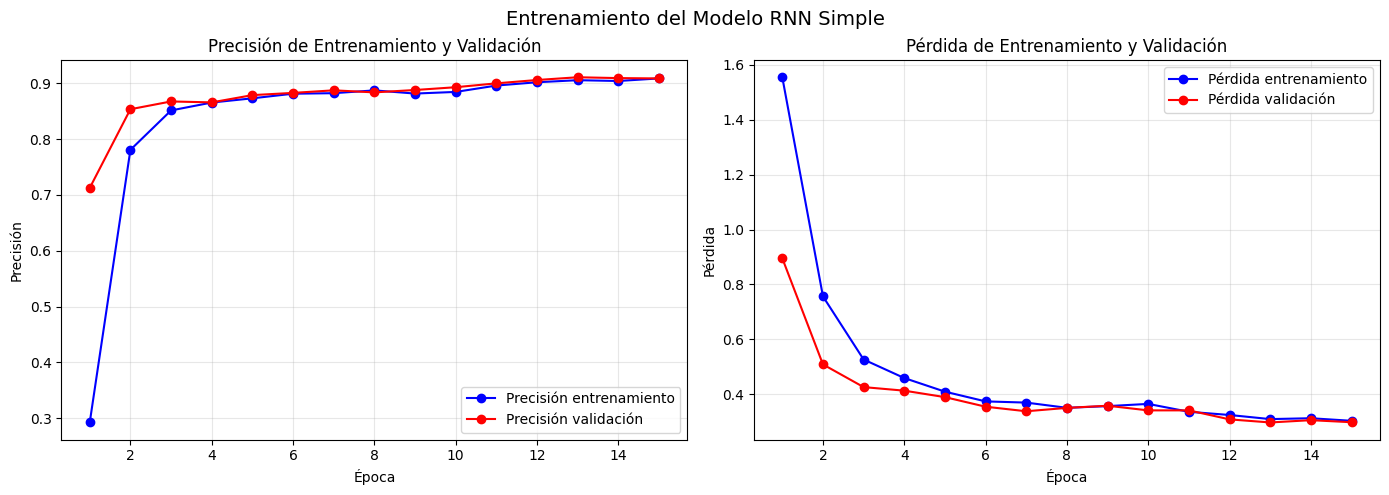

Métricas finales (15 épocas):
  Precisión entrenamiento: 0.9087
  Precisión validación: 0.9087
  Pérdida entrenamiento: 0.3042
  Pérdida validación: 0.2990

Mejor rendimiento (época 13):
  Precisión validación: 0.9107
  Pérdida validación: 0.2981

Brecha de entrenamiento-validación: -0.0000
✓ No hay señales significativas de sobreajuste.


In [36]:
# Visualizamos el entrenamiento
visualizar_entrenamiento_recurrente(
    history_rnn_simple, 
    "Entrenamiento del Modelo RNN Simple"
)

### Evaluación de RNN

Se evaluará el rendimiento del RNN, visualizando la matriz de confusión y las métricas de precission, recall y f1-score. También se podrá ver la curva de aprendizaje.

In [37]:
# Función para evaluar modelos recurrentes
def evaluar_modelo_recurrente(modelo, datos, conjunto='Validación'):
    """
    Evalúa un modelo recurrente en un conjunto de datos.
    
    Args:
        modelo: Modelo entrenado
        datos: Diccionario con datos
        conjunto: 'Validación' o 'Prueba'
        
    Returns:
        Diccionario con métricas de evaluación
    """
    # Seleccionamos datos según el conjunto
    if conjunto.lower() == 'validación' or conjunto.lower() == 'validacion':
        X = datos['X_val']
        y = datos['y_val']
        textos = X_val
    else:  # Prueba por defecto
        X = datos['X_test']
        y = datos['y_test']
        textos = X_test
    
    # Realizamos predicciones
    y_pred_prob = modelo.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculamos métricas
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred, target_names=datos['idiomas'], output_dict=True)
    
    # Visualizamos matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=datos['idiomas'], yticklabels=datos['idiomas'])
    plt.title(f'Matriz de Confusión - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Mostramos métricas
    print(f"Resultados en conjunto de {conjunto}:")
    print(f"Precisión global: {accuracy:.4f}\n")
    print("Métricas por clase:")
    
    # Creamos DataFrame para mejor visualización
    metrics_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in datos['idiomas']],
        'Recall': [report[label]['recall'] for label in datos['idiomas']],
        'F1-Score': [report[label]['f1-score'] for label in datos['idiomas']],
        'Support': [report[label]['support'] for label in datos['idiomas']]
    }, index=datos['idiomas'])
    
    display(metrics_df)
    
    # Visualizamos métricas principales
    plt.figure(figsize=(12, 5))
    
    # Precision, Recall, F1 por clase
    metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 5))
    plt.title(f'Métricas por Clase - Conjunto de {conjunto}', fontsize=14)
    plt.ylabel('Valor', fontsize=12)
    plt.xlabel('Intención', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Métrica')
    plt.tight_layout()
    plt.show()
    
    # Analizamos ejemplos incorrectos
    incorrect_indices = np.where(y != y_pred)[0]
    if len(incorrect_indices) > 0:
        print(f"\nEjemplos incorrectamente clasificados ({len(incorrect_indices)}):")
        
        # Mostramos algunos ejemplos representativos
        selected_indices = incorrect_indices[:min(5, len(incorrect_indices))]
        
        for idx in selected_indices:
            # Obtenemos el texto original
            texto_original = textos[idx]
            
            # Convertimos secuencia a tokens
            tokens = []
            for token_id in X[idx]:
                if token_id > 0:  # Ignoramos padding (0)
                    word = datos['tokenizer'].index_word.get(token_id, "<OOV>")
                    tokens.append(word)
            
            texto_tokens = " ".join(tokens)
            
            # Obtenemos intenciones y confianzas
            intent_real = datos['idiomas'][y[idx]]
            intent_pred = datos['idiomas'][y_pred[idx]]
            conf_pred = y_pred_prob[idx][y_pred[idx]]
            conf_real = y_pred_prob[idx][y[idx]]
            
            print(f"\nTexto original: '{texto_original}'")
            print(f"Tokens: '{texto_tokens}'")
            print(f"  - Intención real: {intent_real}")
            print(f"  - Intención predicha: {intent_pred}")
            print(f"  - Confianza en predicción: {conf_pred:.4f}")
            print(f"  - Confianza en intención real: {conf_real:.4f}")
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }



Evaluando modelo RNN simple:
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


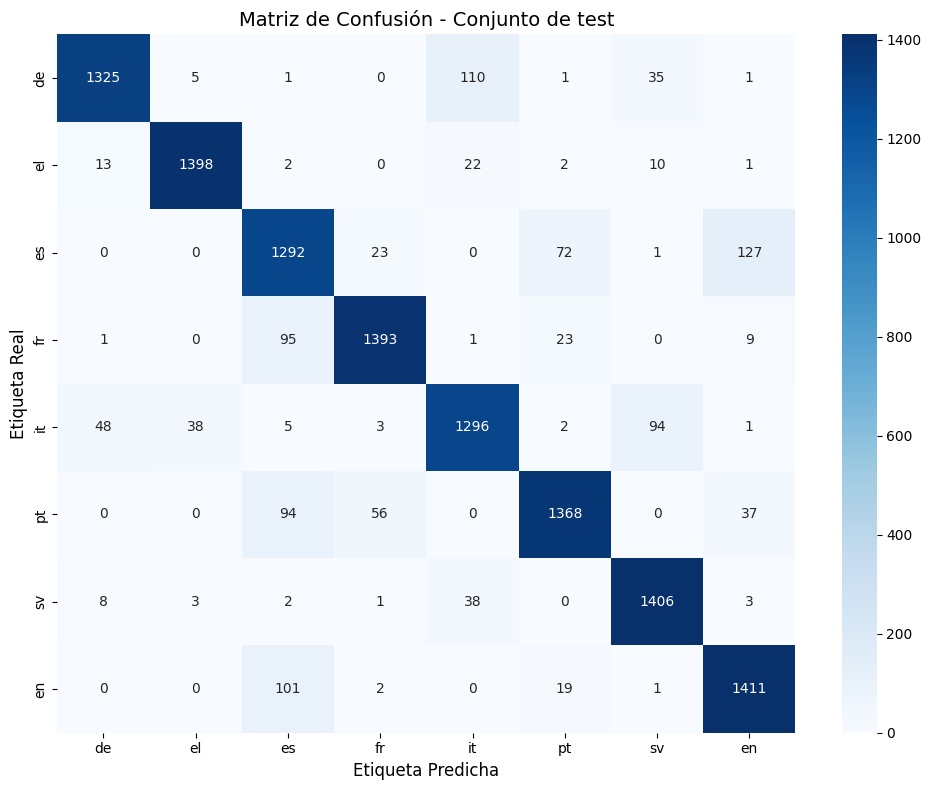

Resultados en conjunto de test:
Precisión global: 0.9074

Métricas por clase:


,Precision,Recall,F1-Score,Support
de,0.949821,0.896482,0.922381,1478.0
el,0.968144,0.965470,0.966805,1448.0
es,0.811558,0.852805,0.831670,1515.0
fr,0.942490,0.915243,0.928667,1522.0
it,0.883436,0.871553,0.877454,1487.0
pt,0.919973,0.879743,0.899408,1555.0
sv,0.908856,0.962355,0.934840,1461.0
en,0.887421,0.919817,0.903329,1534.0


<Figure size 1200x500 with 0 Axes>

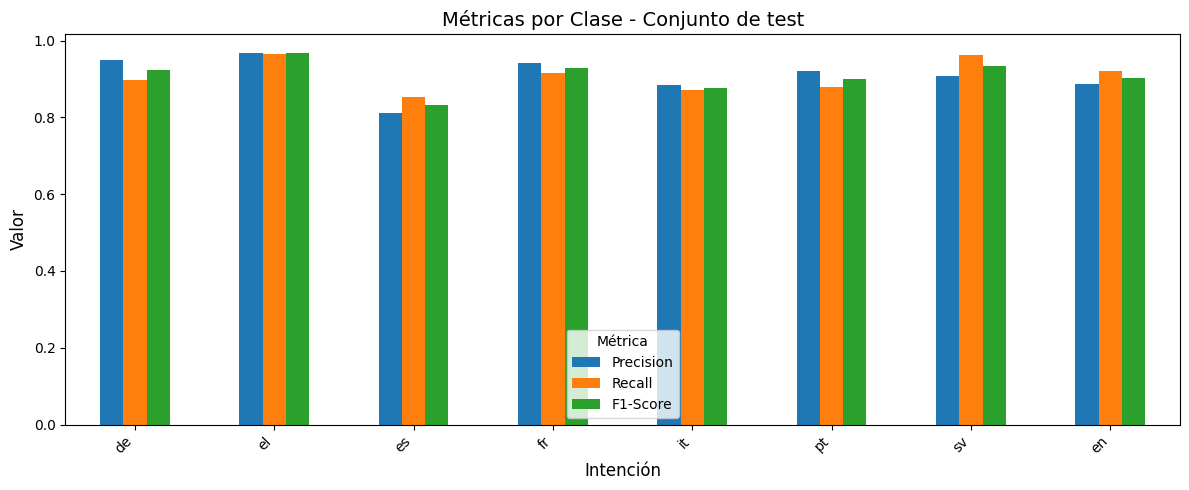


Ejemplos incorrectamente clasificados (1111):

Texto original: 'i diritti delle donne sono sistematicamente violati in tutto il mondo'
Tokens: 'i diritti delle donne sono sistematicamente <OOV> in tutto il mondo'
  - Intención real: it
  - Intención predicha: sv
  - Confianza en predicción: 0.6880
  - Confianza en intención real: 0.2292

Texto original: 'no mundo globalizado de hoje isto torna­se ainda mais patente'
Tokens: 'no mundo <OOV> de hoje isto <OOV> ainda mais patente'
  - Intención real: pt
  - Intención predicha: es
  - Confianza en predicción: 0.9741
  - Confianza en intención real: 0.0078

Texto original: 'cara colega rothbehrendt já existe o tüv para navios'
Tokens: 'cara colega rothbehrendt já existe o <OOV> para navios'
  - Intención real: pt
  - Intención predicha: en
  - Confianza en predicción: 0.6959
  - Confianza en intención real: 0.0458

Texto original: 'si conseguimos esto habremos globalizado una importante idea de política medioambiental'
Tokens: 'si consegui

In [38]:
# Evaluamos el modelo RNN simple
print("\nEvaluando modelo RNN simple:")
eval_rnn_simple = evaluar_modelo_recurrente(
    modelo_rnn_simple,
    datos_recurrentes,
    conjunto='test'
)

### Implementación de modelo BLSTM

A continuación, se implementará el modelo BLSTM. Se ha elegido este modelo porque es el que mejor resultados produce de entre los modelos secuenciales. De esta manera, se podrá comprobar si mejora los resultados de Naive Bayes.

In [39]:
# Función para crear modelo LSTM bidireccional
def crear_modelo_lstm_bidireccional(vocab_size, embedding_dim, max_length, num_classes, dropout_rate=0.3):
    """
    Crea un modelo LSTM bidireccional para detección de intenciones.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión de los embeddings
        max_length: Longitud máxima de las secuencias
        num_classes: Número de clases (intenciones)
        dropout_rate: Tasa de dropout para regularización
        
    Returns:
        Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    ))
    
    # Capa LSTM bidireccional
    model.add(Bidirectional(LSTM(
        units=64,  # Reducimos unidades porque al ser bidireccional se duplican
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate/2
    )))
    
    # Capa de regularización
    model.add(Dropout(dropout_rate))
    
    # Capa densa intermedia
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    
    # Capa densa de salida
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compilamos el modelo
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Mostramos el resumen
    model.summary()
    
    return model

In [40]:
# Creamos el modelo LSTM bidireccional
modelo_bilstm = crear_modelo_lstm_bidireccional(
    vocab_size=datos_recurrentes['vocab_size'],
    embedding_dim=datos_recurrentes['embedding_dim'],
    max_length=datos_recurrentes['max_length'],
    num_classes=datos_recurrentes['num_classes']
)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Entrenamos el modelo LSTM bidireccional
print("\nEntrenando modelo LSTM bidireccional:")
history_bilstm = entrenar_modelo_recurrente(
    modelo_bilstm,
    datos_recurrentes,
    "modelo_bilstm",
    epochs=20
)


Entrenando modelo LSTM bidireccional:
Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 34s 16ms/step - accuracy: 0.8417 - loss: 0.4521 - val_accuracy: 0.9951 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9955 - loss: 0.0170 - val_accuracy: 0.9941 - val_loss: 0.0212 - learning_rate: 0.0010
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9972 - loss: 0.0096 - val_accuracy: 0.9958 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9960 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9940 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 6/20
1747/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9985 - loss: 0.0050
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1750/1750 ━━━━━━

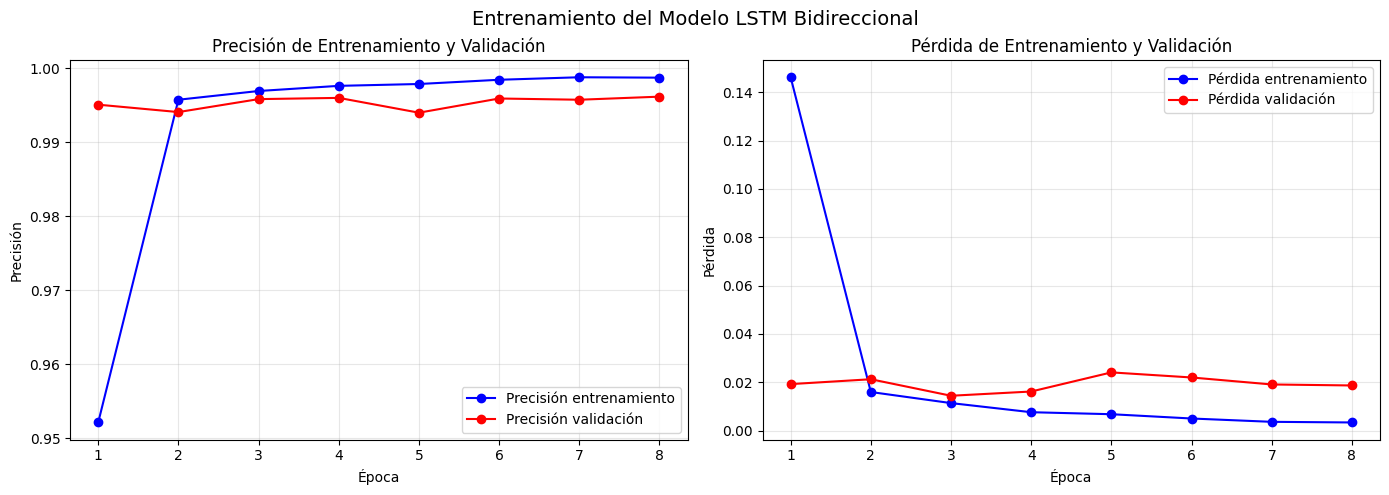

Métricas finales (8 épocas):
  Precisión entrenamiento: 0.9987
  Precisión validación: 0.9962
  Pérdida entrenamiento: 0.0033
  Pérdida validación: 0.0186

Mejor rendimiento (época 8):
  Precisión validación: 0.9962
  Pérdida validación: 0.0186

Brecha de entrenamiento-validación: 0.0026
✓ No hay señales significativas de sobreajuste.


In [42]:
# Visualizamos el entrenamiento
visualizar_entrenamiento_recurrente(
    history_bilstm, 
    "Entrenamiento del Modelo LSTM Bidireccional"
)

### Evaluación de BLSTM


Evaluando modelo LSTM bidireccional:
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


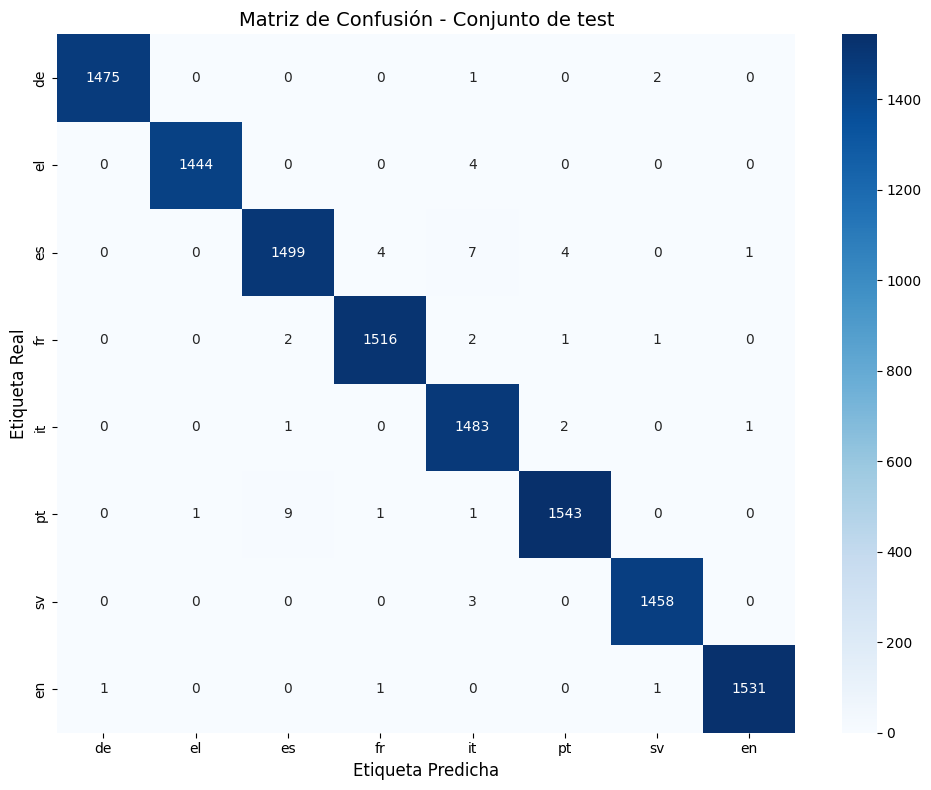

Resultados en conjunto de test:
Precisión global: 0.9958

Métricas por clase:


,Precision,Recall,F1-Score,Support
de,0.999322,0.997970,0.998646,1478.0
el,0.999308,0.997238,0.998272,1448.0
es,0.992058,0.989439,0.990747,1515.0
fr,0.996058,0.996058,0.996058,1522.0
it,0.988008,0.997310,0.992637,1487.0
pt,0.995484,0.992283,0.993881,1555.0
sv,0.997264,0.997947,0.997605,1461.0
en,0.998695,0.998044,0.998370,1534.0


<Figure size 1200x500 with 0 Axes>

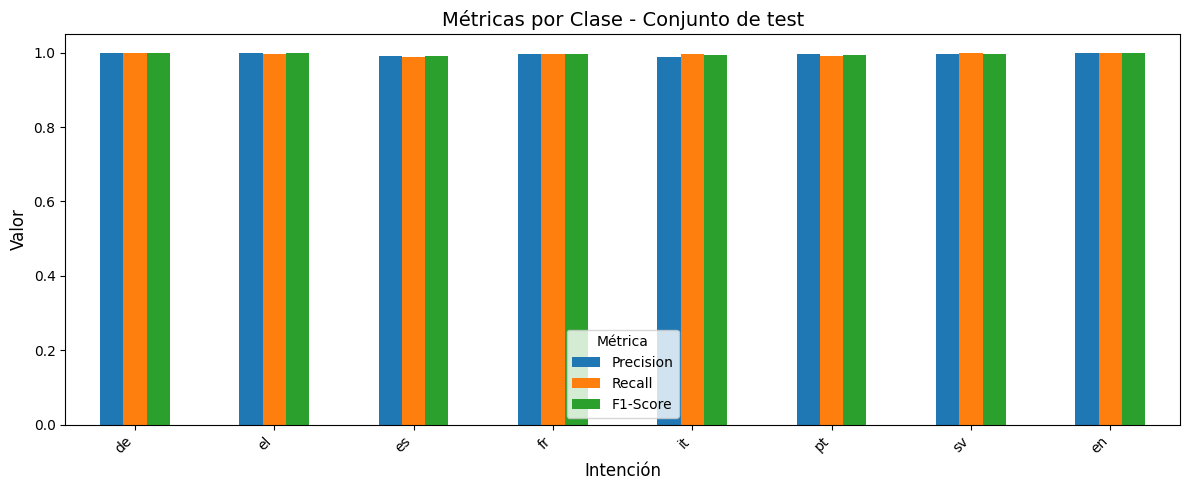


Ejemplos incorrectamente clasificados (51):

Texto original: 'quieren resultados'
Tokens: 'quieren resultados'
  - Intención real: es
  - Intención predicha: pt
  - Confianza en predicción: 0.8159
  - Confianza en intención real: 0.1638

Texto original: '¡sólo un'
Tokens: '<OOV> un'
  - Intención real: es
  - Intención predicha: it
  - Confianza en predicción: 0.9120
  - Confianza en intención real: 0.0623

Texto original: 'herr monti'
Tokens: 'herr monti'
  - Intención real: de
  - Intención predicha: sv
  - Confianza en predicción: 0.9994
  - Confianza en intención real: 0.0005

Texto original: 'no not this time either'
Tokens: 'no not this time either'
  - Intención real: es
  - Intención predicha: en
  - Confianza en predicción: 0.3350
  - Confianza en intención real: 0.1761

Texto original: 'quanto mais'
Tokens: 'quanto mais'
  - Intención real: pt
  - Intención predicha: it
  - Confianza en predicción: 0.3262
  - Confianza en intención real: 0.2094


In [43]:
# Evaluamos el modelo LSTM bidireccional
print("\nEvaluando modelo LSTM bidireccional:")
eval_bilstm = evaluar_modelo_recurrente(
    modelo_bilstm,
    datos_recurrentes,
    conjunto='test'
)

Como vemos, el rendimiento del BLSTM es muy alto, aunque se queda por debajo de Naive Bayes. De igual manera que en este modelo, se visualizarán las frases incorrectamente clasificadas.

In [44]:
#print(type(eval_bilstm['y_pred']))
ind_errores_bilstm = np.where(CLASES[eval_bilstm['y_pred']] != y_test)[0]
print(ind_errores_bilstm)

[  441   446   490   698  1277  1359  1524  1732  1864  2459  2590  2740
  3029  3596  3752  3950  4430  4946  5012  5215  5219  5290  5358  5509
  5519  5596  5751  5856  5940  6223  6345  6358  6596  6861  6994  7223
  7857  8559  8807  8922  9068  9329  9566  9851  9876 10038 10593 10661
 11384 11621 11791]


In [45]:
df_errores = pd.DataFrame({
    "Texto": X_test[ind_errores_bilstm],
    "Clase Verdadera": y_test[ind_errores_bilstm],
    "Clase predicha": CLASES[eval_bilstm['y_pred'][ind_errores_bilstm]],
    "Confianza": np.max(eval_bilstm['y_pred_prob'][ind_errores_bilstm],axis=1)
})

print("Todos los errores de BLSTM:")
print("")

for id in CLASES:
        print("Clase verdadera:",id,f"({IDIOMAS[id]})")
        df_id = df_errores[df_errores['Clase Verdadera'] == id]
        display(df_id)

Todos los errores de BLSTM:

Clase verdadera: de (alemán)


,Texto,Clase Verdadera,Clase predicha,Confianza
2,herr monti,de,sv,0.999410
11,danke herr poettering,de,sv,0.611612
38,herzlichen glückwunsch,de,it,0.431220


Clase verdadera: el (griego)


,Texto,Clase Verdadera,Clase predicha,Confianza
10,fr ενεργούμε υπερβολικά,el,it,0.516040
22,αεροπλάνα hushkits,el,it,0.431220
27,μάλλον πάμε χειρότερα,el,it,0.435753
44,συμβουλευόμαστε δικηγόρο,el,it,0.431220


Clase verdadera: es (español)


,Texto,Clase Verdadera,Clase predicha,Confianza
0,quieren resultados,es,pt,0.815866
1,¡sólo un,es,it,0.912006
3,no not this time either,es,en,0.335022
8,perseveraremos con medidas semejantes,es,it,0.921894
12,nos hallamos en un procedimiento de codecisión,es,fr,0.578097
18,lo dije claramente,es,it,0.723420
19,nunca antes tantos países han ratificado tantos tratados internacionales,es,pt,0.914397
20,irak no muere de hambre,es,fr,0.835232
23,la felicitamos,es,it,0.742336
28,¡subsisten lagunas,es,it,0.431220


Clase verdadera: fr (francés)


,Texto,Clase Verdadera,Clase predicha,Confianza
5,questce que le nationalisme,fr,es,0.438277
7,respectonsen la garantie gustative,fr,es,0.569597
14,rapport dimitrakopoulos leinen a,fr,sv,0.756252
30,faisonsnous entendre,fr,it,0.431220
40,leussiezvous cru,fr,it,0.431220
42,que voientils,fr,pt,0.560818


Clase verdadera: it (italiano)


,Texto,Clase Verdadera,Clase predicha,Confianza
9,com c cod,it,pt,0.999442
21,where is the beef,it,en,0.806701
29,collabora o no a tale sistema,it,pt,0.647098
35,essa ha risentito enormemente del flusso dei profughi durante la guerra del kosovo,it,es,0.995119


Clase verdadera: pt (portugués)


,Texto,Clase Verdadera,Clase predicha,Confianza
4,quanto mais,pt,it,0.326195
6,monsieur prodi préparez votre défense cest la défense de leurope,pt,es,0.287430
15,para se ser eleito conselheiro local basta querer­se,pt,es,0.982035
24,podemos citar a comunicação,pt,es,0.892708
25,está totalmente previsto no regimento,pt,es,0.994353
26,por vezes faltamnos realizadores competentes que nos motivem,pt,es,0.876369
33,se for preciso financiar novas políticas haverá que encontrar novos financiamentos,pt,es,0.931624
36,estamos à procura de soluções,pt,fr,0.496385
41,tal como a europol,pt,es,0.905030
43,evans robert pse,pt,el,0.508912


Clase verdadera: sv (sueco)


,Texto,Clase Verdadera,Clase predicha,Confianza
17,alla berömvärda saker,sv,it,0.989854
39,england öppnar åter sin ambassad i khartum,sv,it,0.451473
46,föredragande marienoëlle lienemann,sv,it,0.334602


Clase verdadera: en (inglés)


,Texto,Clase Verdadera,Clase predicha,Confianza
13,i suppose i can not win,en,sv,0.733829
16,i have a related point,en,fr,0.325074
50,back in july strasbourg was labouring under ozone smog,en,de,0.424910


En este caso, existen muchas frases para las que no existe una explicación obvia de su incorrecta clasificación. Incluso algunos textos en griego, con sus propios caracteres, han sido mal clasificado.

Se visualizará la distribución de la longitud de las frases erróneas:

In [47]:
longitud_errores = np.array([len(df_errores['Texto'][i].split()) for i in range(len(df_errores))])
df_errores['Longitud'] = longitud_errores

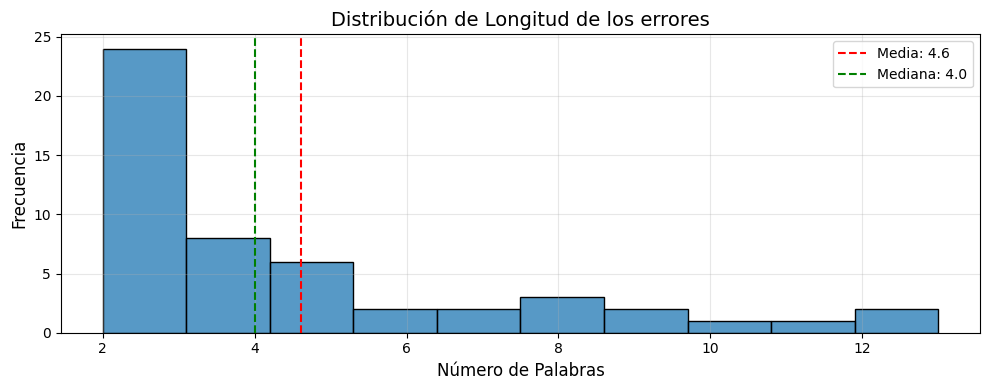

In [48]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_errores, x='Longitud', bins=10, kde=False)
plt.axvline(df_errores['Longitud'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_errores['Longitud'].mean():.1f}')
plt.axvline(df_errores['Longitud'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_errores['Longitud'].median():.1f}')
plt.title('Distribución de Longitud de los errores', fontsize=14)
plt.xlabel('Número de Palabras', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Vemos que aquí, al igual que pasaba con Naive Bayes, predominan las frases de menor número de palabras.

Es interesante analizar también la distribución de la confianza de la predicción:

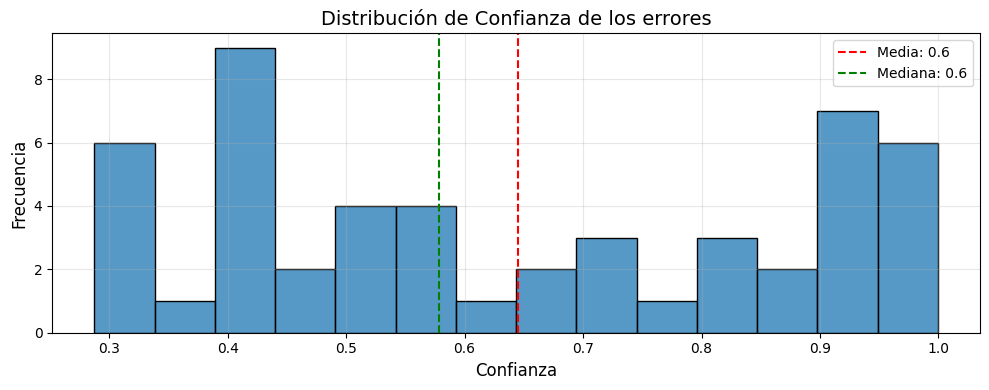

In [49]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_errores, x='Confianza', bins=14, kde=False)
plt.axvline(df_errores['Confianza'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_errores['Confianza'].mean():.1f}')
plt.axvline(df_errores['Confianza'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_errores['Confianza'].median():.1f}')
plt.title('Distribución de Confianza de los errores', fontsize=14)
plt.xlabel('Confianza', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Esta distribución parece indicar que la confianza puede tomar cualquier valor en las predicciones erróneas. A continuación, se presenta la distribución de confianza de todas las predicciones del conjunto de test:

In [50]:
df_test = pd.DataFrame({
    "Texto": X_test,
    "Clase Verdadera": y_test,
    "Clase predicha": CLASES[eval_bilstm['y_pred']],
    "Confianza": np.max(eval_bilstm['y_pred_prob'],axis=1)
})

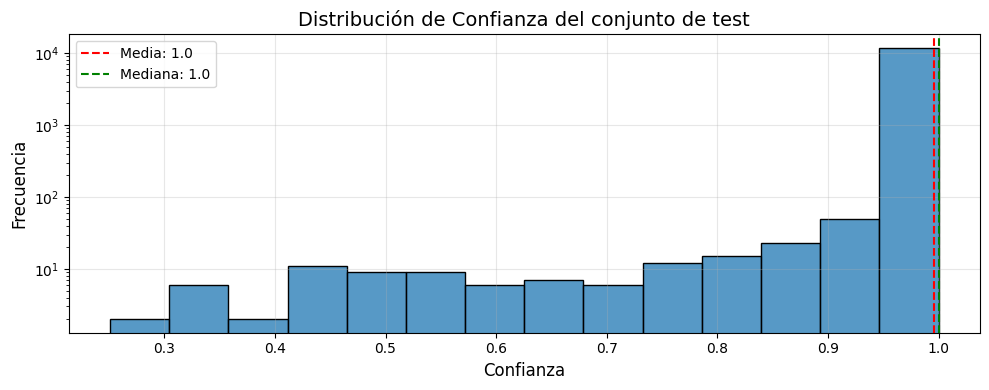

In [51]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_test, x='Confianza', bins=14, kde=False)
plt.axvline(df_test['Confianza'].mean(), color='red', linestyle='--', 
            label=f'Media: {df_test['Confianza'].mean():.1f}')
plt.axvline(df_test['Confianza'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_test['Confianza'].median():.1f}')
plt.title('Distribución de Confianza del conjunto de test', fontsize=14)
plt.xlabel('Confianza', fontsize=12)
plt.yscale('log')
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

En este caso, la gran mayoría de las predicciones se encuentran entre 0.95 y 1.0 de confianza (nótese la escala logarítmica). Por tanto, los errores representan una buena proporción de los casos de confianza baja. Esto quiere decir que este indicador es bueno para poder valorar si el modelo se ha equivocado podido equivocar al realizar una predicción.